In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import sys
warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth',100)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
df = pd.read_csv(r"C:\Users\nicka\OneDrive\Рабочий стол\all_data.csv",sep = ';',encoding = 'cp1251',index_col=0) #index_col=0 для того чтобы не было
df.sample(10)

,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
8031,CENTURY 21 Перспектива,real_estate_agent,https://lyubertsy.cian.ru/sale/flat/284880366/,Москва_и_др.,sale,flat,9,12,1,37.7,157824,5950000,1984,20.4,10.0,79645675472,NaN,NaN,NaN,NaN
8254,Желтый квадрат,real_estate_agent,https://chekhov.cian.ru/sale/flat/286262528/,Москва_и_др.,sale,flat,10,16,2,60.3,99502,5999999,2009,33.3,-1.0,79647741104,NaN,NaN,NaN,NaN
4572,Самолет плюс - Химки,real_estate_agent,https://www.cian.ru/sale/flat/285702468/,Москва_и_др.,sale,flat,13,27,1,25.0,564000,14100000,2020,15.0,5.0,79660638926,Хорошево-Мневники,Шелепихинская набережная,NaN,FreeDOM
7156,Мегаполис-Сервис,real_estate_agent,https://elektrostal.cian.ru/sale/flat/285537007/,Москва_и_др.,sale,flat,12,17,1,28.0,117857,3300000,2022,15.0,5.0,79637782489,NaN,NaN,NaN,NaN
1969,Kalinka Group,real_estate_agent,https://www.cian.ru/sale/flat/278538452/,Москва_и_др.,sale,flat,12,53,4,150.0,866666,130000000,2012,-1.0,-1.0,79154194125,Раменки,Мосфильмовская,Минская,Дом на Мосфильмовской
2044,PEOPLE,real_estate_agent,https://www.cian.ru/sale/flat/274203092/,Москва_и_др.,sale,flat,9,19,4,140.0,625357,87550000,2018,-1.0,-1.0,79660513611,Хорошево-Мневники,Шелепихинская набережная,Шелепиха,Сердце Столицы
7265,Мега-Сити,real_estate_agent,https://korolev.cian.ru/sale/flat/287624278/,Москва_и_др.,sale,flat,13,17,-1,24.7,153846,3800000,2020,15.0,5.0,79153601733,NaN,NaN,Медведково,NaN
10706,МЕЗОН,real_estate_agent,https://www.cian.ru/sale/flat/281342657/,Москва_и_др.,sale,flat,30,39,4,107.0,401869,43000000,2022,-1.0,-1.0,79851825136,Раменки,Лобачевского,Аминьевская,Крылья
523,Msk Estate,real_estate_agent,https://www.cian.ru/sale/flat/280736011/,Москва_и_др.,sale,flat,2,6,1,27.2,225488,6133277,-1,19.2,3.0,79852852531,Коптево,Клары Цеткин,Войковская,NaN
33,RED,real_estate_agent,https://www.cian.ru/sale/flat/287201428/,Москва_и_др.,sale,flat,4,27,1,47.4,411392,19500000,2022,-1.0,20.0,79057199087,Раменки,Янковского,Аминьевская,Событие


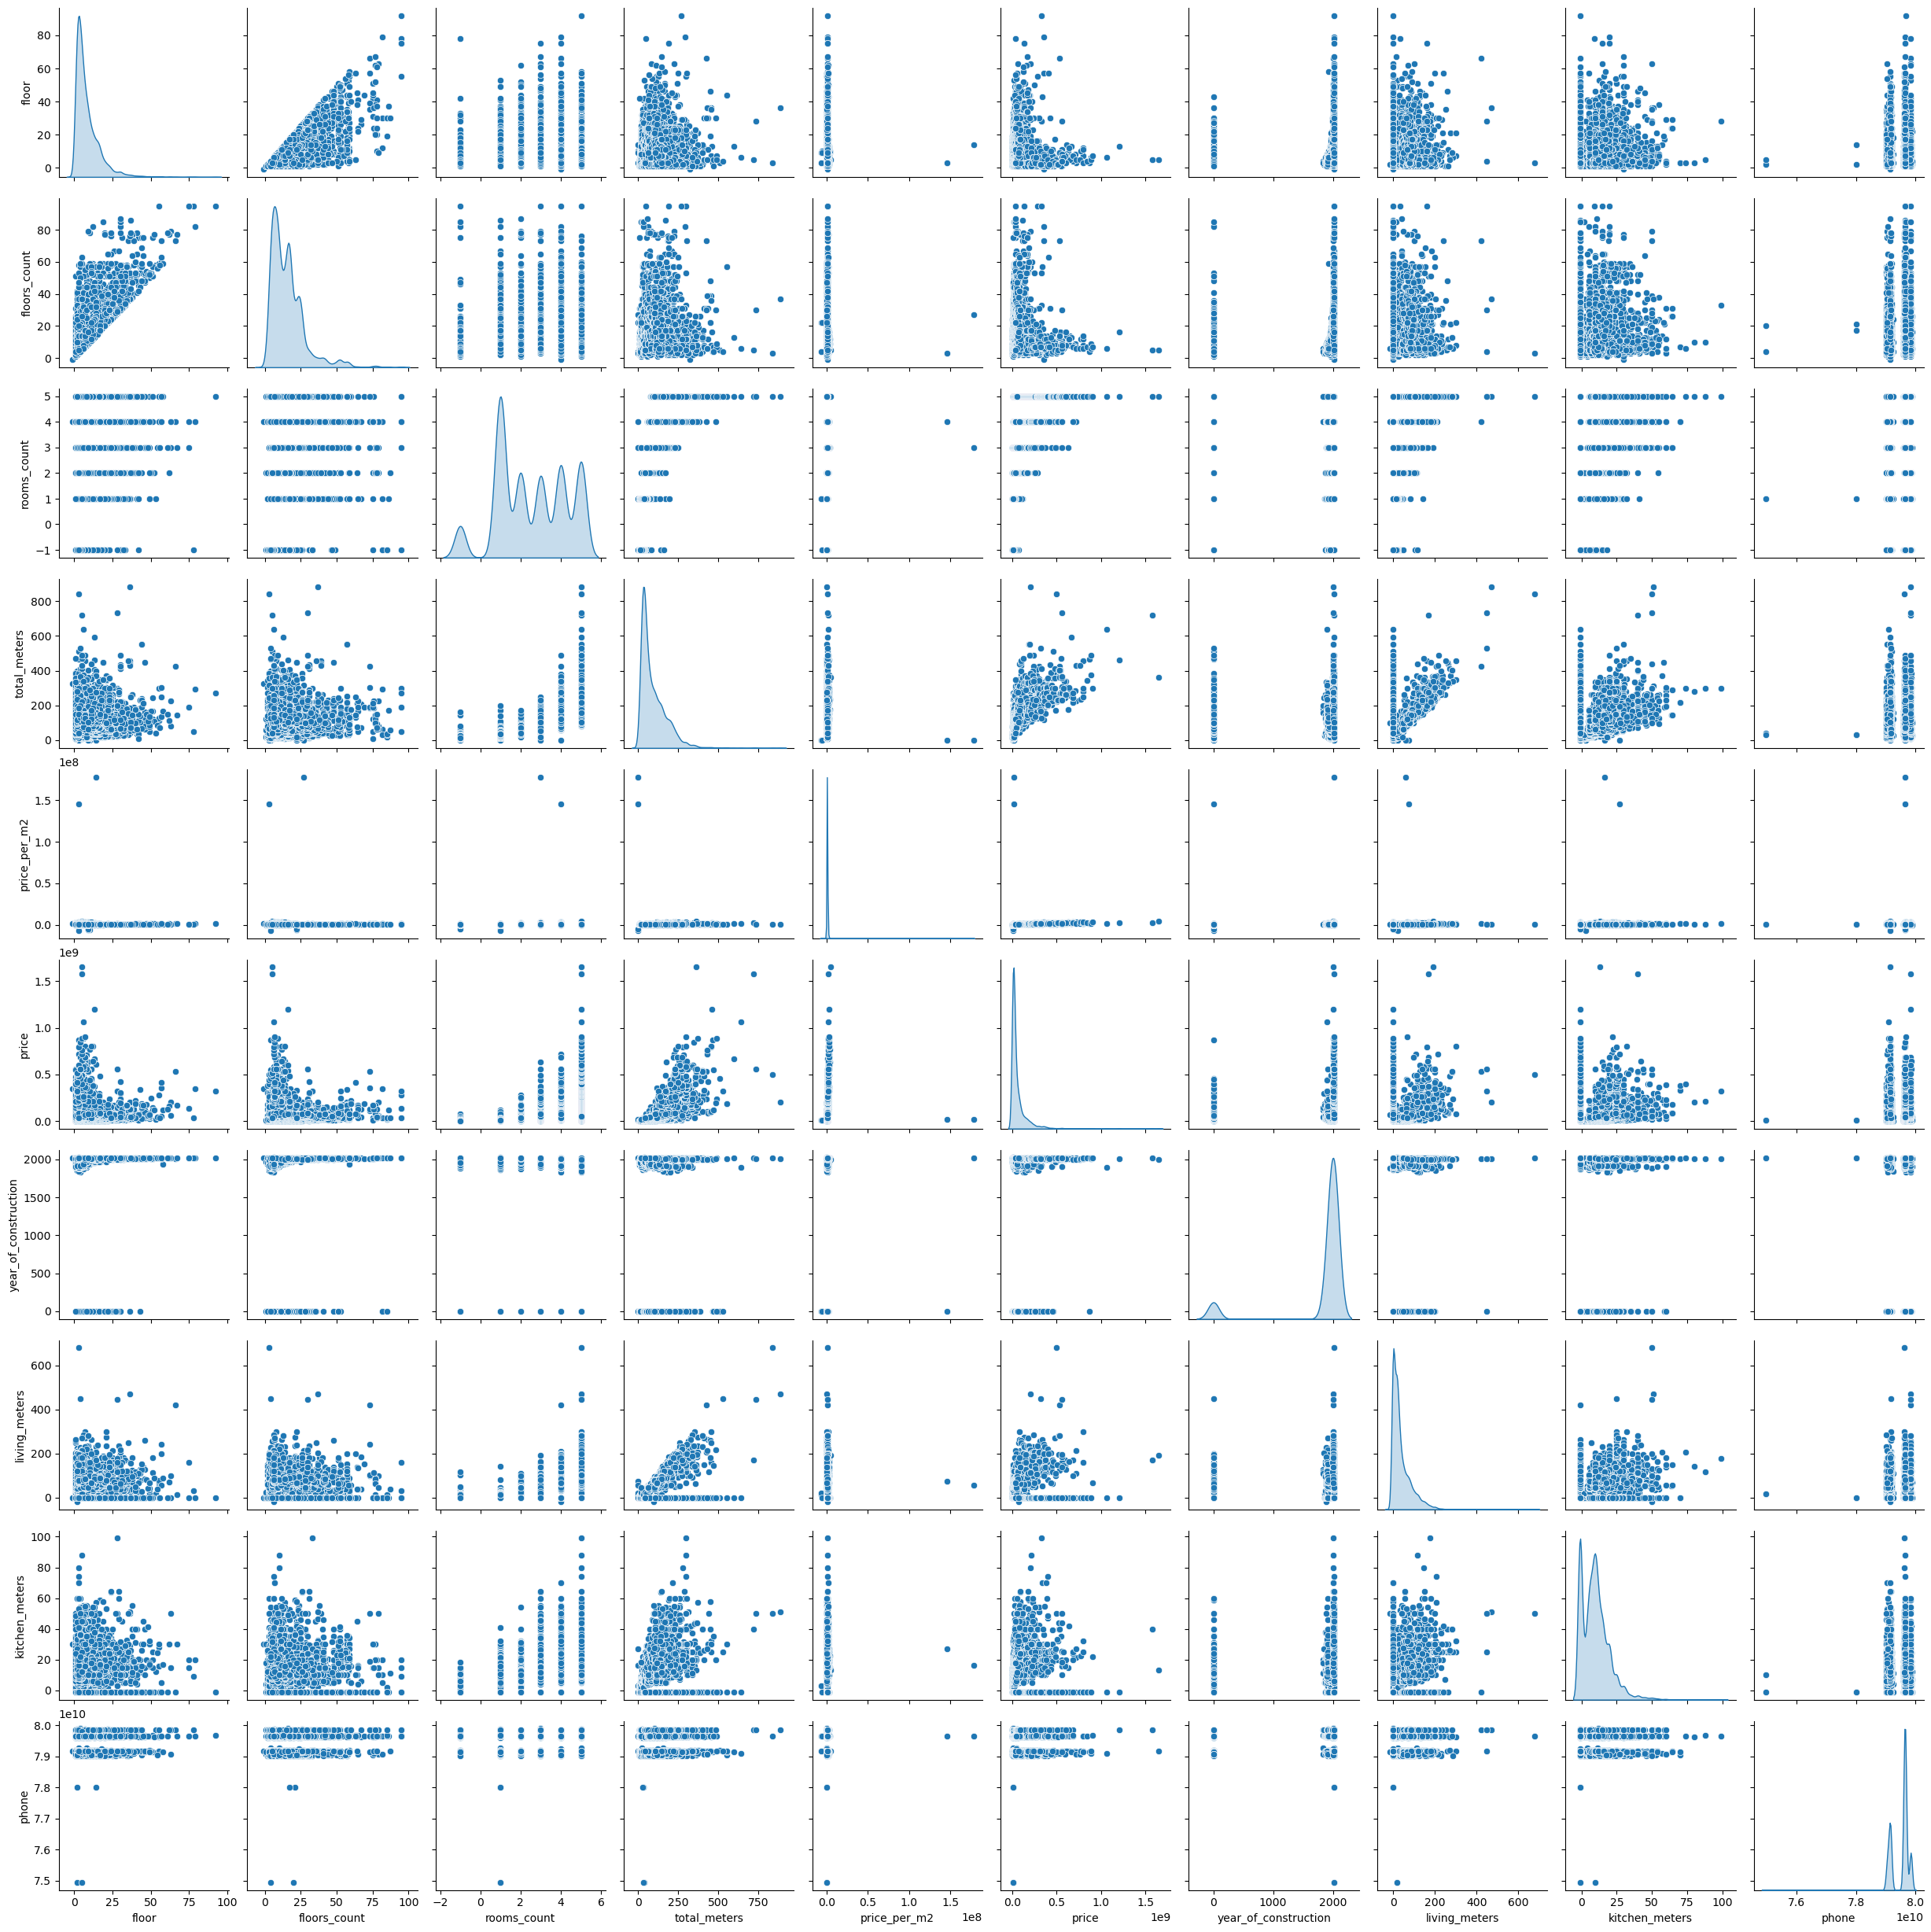

In [123]:
sns.pairplot(data=df, diag_kind='kde')

<Axes: >

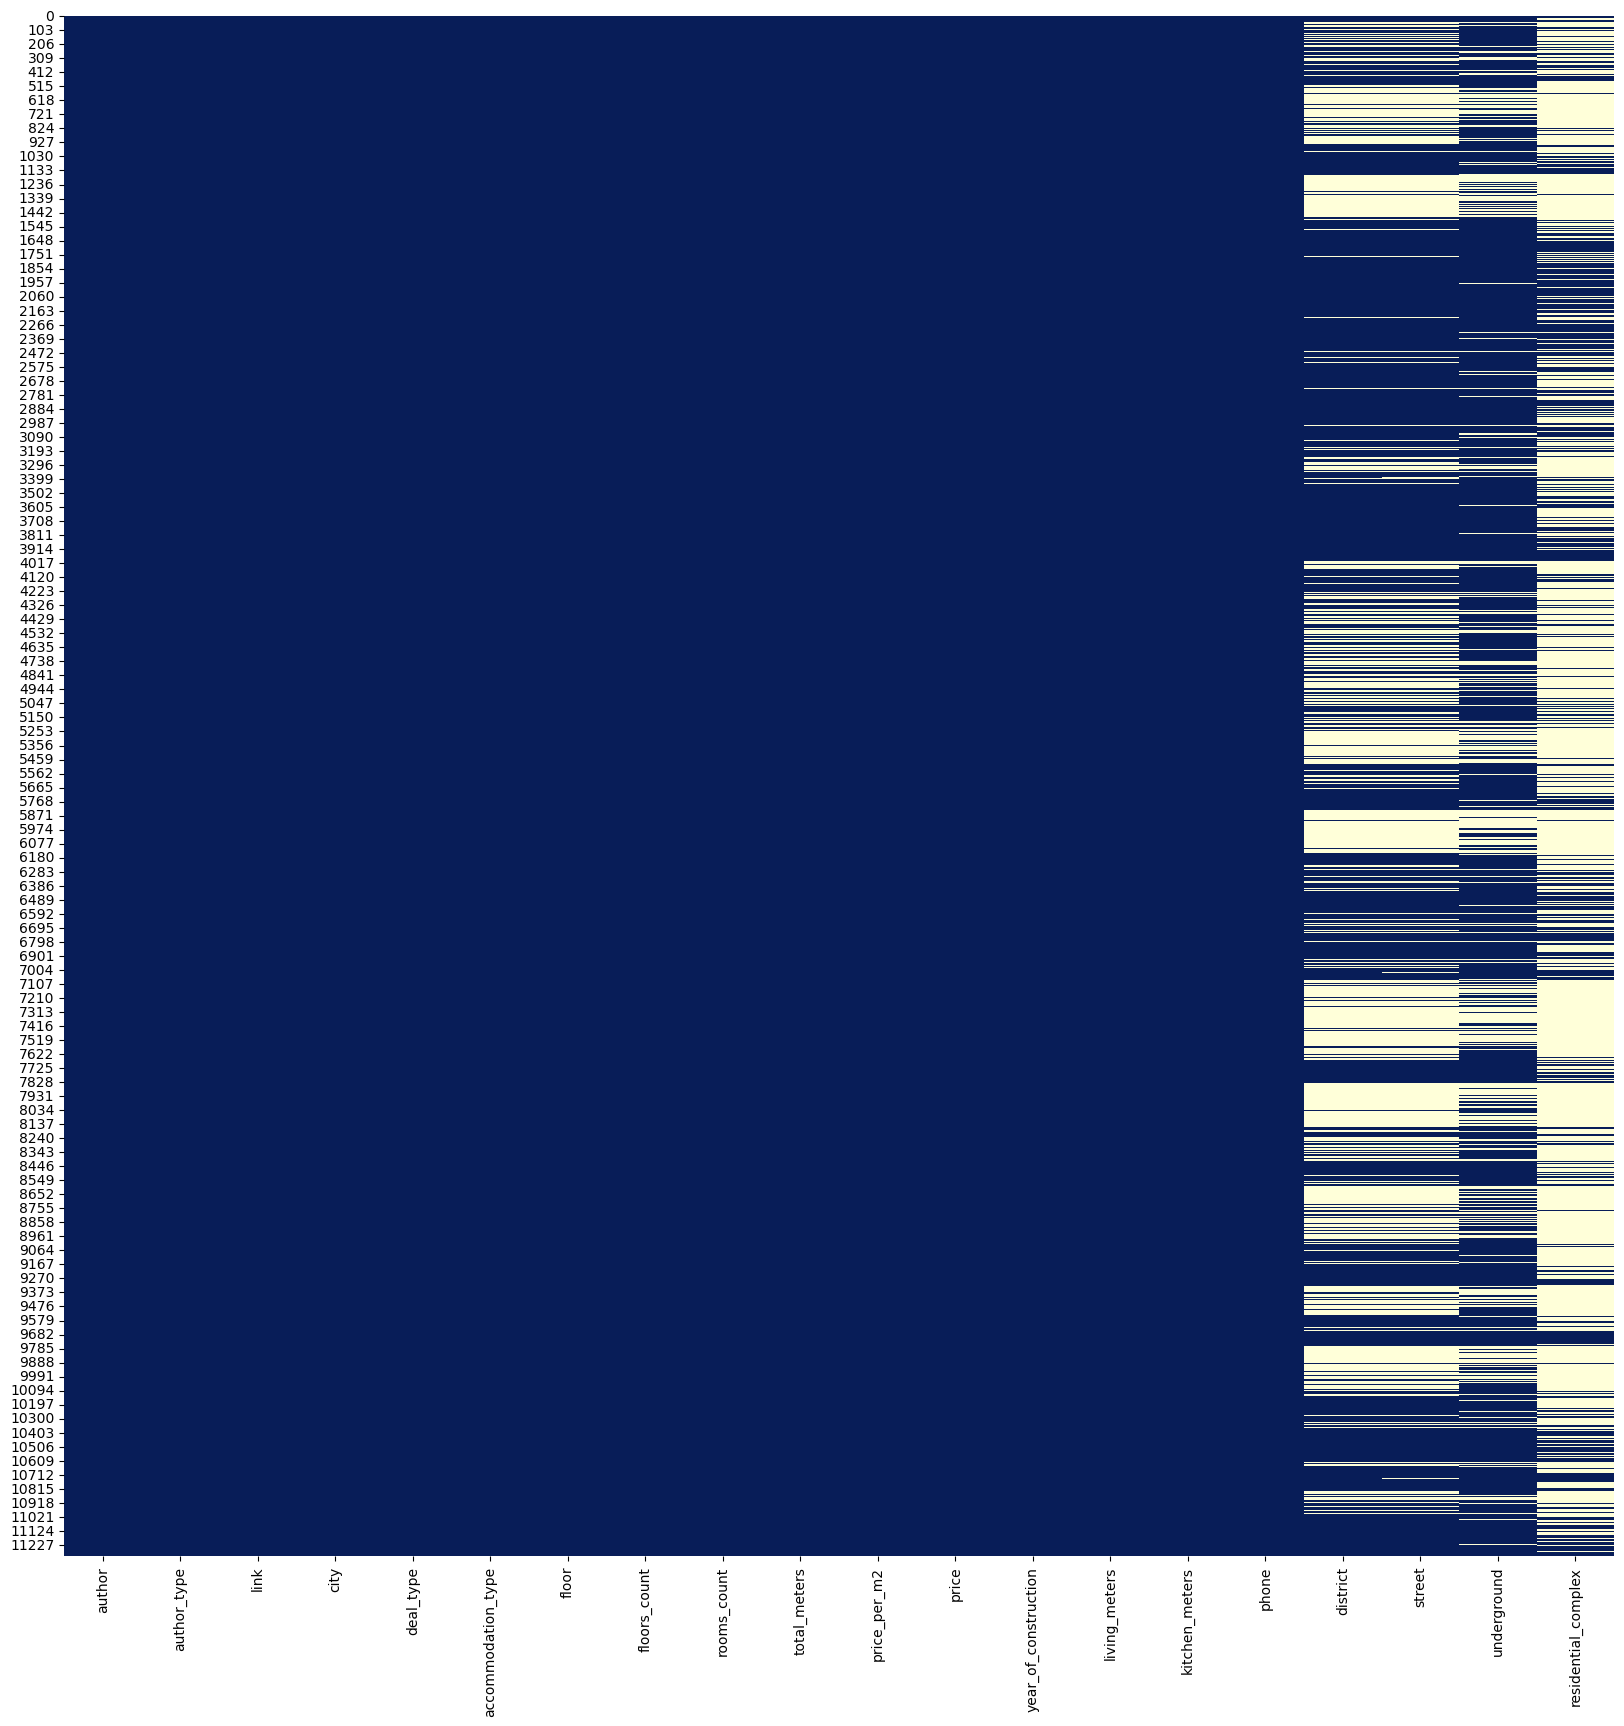

In [4]:
plt.figure(figsize = (20,20))
sns.heatmap(data = df.isnull(),cmap="YlGnBu_r",cbar=False)

In [5]:
df.isna().sum()/df.shape[0]*100

author                   0.035367
author_type              0.035367
link                     0.000000
city                     0.000000
deal_type                0.000000
accommodation_type       0.000000
floor                    0.000000
floors_count             0.000000
rooms_count              0.000000
total_meters             0.000000
price_per_m2             0.000000
price                    0.000000
year_of_construction     0.000000
living_meters            0.000000
kitchen_meters           0.000000
phone                    0.000000
district                36.118479
street                  36.251105
underground             21.786030
residential_complex     67.559682
dtype: float64

In [6]:
df.head(100)

,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
0,Константин Кудрявцев,realtor,https://www.cian.ru/sale/flat/283849683/,Москва_и_др.,sale,flat,1,5,1,12.00,291666,3500000,-1,-1.0,-1.0,79660408670,Текстильщики,Шкулева,Волжская,NaN
1,White and Broughton,real_estate_agent,https://www.cian.ru/sale/flat/280986757/,Москва_и_др.,sale,flat,17,41,1,40.40,618811,25000000,2021,15.2,9.1,79646331510,Хорошевский,Ленинградский проспект,Аэропорт,Прайм Парк
2,Времена года,real_estate_agent,https://www.cian.ru/sale/flat/286530258/,Москва_и_др.,sale,flat,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,79152007823,Хамовники,Усачева,Спортивная,Садовые кварталы
3,White and Broughton,real_estate_agent,https://www.cian.ru/sale/flat/283638079/,Москва_и_др.,sale,flat,9,41,1,40.50,617283,25000000,2022,17.3,9.3,79646331510,Хорошевский,Ленинградский проспект,Аэропорт,Прайм Парк
4,ID 44396977,realtor,https://www.cian.ru/sale/flat/287127196/,Москва_и_др.,sale,flat,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,79034356129,Нагатино-Садовники,Нагатинская набережная,Коломенская,NaN
5,Времена года,real_estate_agent,https://www.cian.ru/sale/flat/285378586/,Москва_и_др.,sale,flat,6,13,1,71.10,983122,69900000,2019,37.1,12.8,79152007823,Хамовники,Усачева,Спортивная,Садовые кварталы
6,ИТКОЛ,official_representative,https://www.cian.ru/sale/flat/287529888/,Москва_и_др.,sale,flat,7,9,1,18.00,382000,6876000,-1,-1.0,-1.0,79651098418,Аэропорт,Большой Коптевский проезд,Красный Балтиец,NaN
7,Century 21 Premium Property,real_estate_agent,https://www.cian.ru/sale/flat/287489122/,Москва_и_др.,sale,flat,33,36,1,75.00,626666,47000000,2020,35.0,20.0,79175213146,Хорошево-Мневники,Шелепихинская набережная,Шелепиха,Сердце Столицы
8,СТРОЙИНВЕСТ,real_estate_agent,https://balashikha.cian.ru/sale/flat/281454196/,Москва_и_др.,sale,flat,9,17,1,37.20,147072,5471080,2022,-1.0,-1.0,79647297235,NaN,NaN,Лухмановская,NaN
9,Whitewill,real_estate_agent,https://www.cian.ru/sale/flat/286402225/,Москва_и_др.,sale,flat,6,41,1,41.00,724390,29700000,2022,24.0,6.0,79165694109,Хорошевский,Ленинградский проспект,Аэропорт,Прайм Парк


In [7]:
df['link']

0        https://www.cian.ru/sale/flat/283849683/
1        https://www.cian.ru/sale/flat/280986757/
2        https://www.cian.ru/sale/flat/286530258/
3        https://www.cian.ru/sale/flat/283638079/
4        https://www.cian.ru/sale/flat/287127196/
                           ...                   
11305    https://www.cian.ru/sale/flat/287703757/
11306    https://www.cian.ru/sale/flat/284652097/
11307    https://www.cian.ru/sale/flat/284644852/
11308    https://www.cian.ru/sale/flat/285604501/
11309    https://www.cian.ru/sale/flat/282401854/
Name: link, Length: 11310, dtype: object

In [8]:
df.shape

(11310, 20)

In [9]:
df = df.drop_duplicates()
df.shape

(8391, 20)

In [10]:
df_cop = df.copy()

# Вычисление ненужных данных

### City

In [11]:
df_cop['city'].unique()

array(['Москва_и_др.'], dtype=object)

In [12]:
df_cop.drop(columns = 'city',inplace = True)

### Ссылка на квартиры нам не понадобиться кроме (!!!!!) того как если бы мы показывали похожие квартиры

In [13]:
df_cop.drop(columns = 'link',inplace = True)

### Deal_type

In [14]:
df_cop['deal_type'].unique()

array(['sale'], dtype=object)

In [15]:
df_cop.drop(columns = 'deal_type',inplace = True)

### Accommodation_type

In [16]:
df_cop['accommodation_type'].unique()

array(['flat'], dtype=object)

In [17]:
df_cop.drop(columns = 'accommodation_type',inplace = True)

### Телефон для нашей модели также не нужен т.к. это индивидуальная информация

In [18]:
df_cop.drop(columns = 'phone',inplace = True)

### Author и Author_type пользователь знать не сможет, т.к. мы просто будем оценивать квартиру

In [19]:
df_cop.drop(columns = ['author','author_type'],inplace = True)

In [20]:
df_cop.sample(20)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,residential_complex
6179,13,22,2,71.20,176966,12600000,2008,39.7,-1.0,NaN,NaN,Пенягино,NaN
9180,10,12,3,64.00,453125,29000000,1974,44.2,7.1,Мещанский,Троицкая,Цветной бульвар,NaN
8762,2,8,2,57.00,157017,8950000,2022,-1.0,-1.0,NaN,NaN,NaN,NaN
3067,10,14,5,201.92,881537,178000000,2022,-1.0,20.0,Хамовники,Усачева,Спортивная,Садовые кварталы
4052,1,3,5,133.80,187219,25050000,2022,-1.0,-1.0,NaN,NaN,NaN,NaN
1731,7,12,3,85.00,264705,22500000,1996,52.0,10.0,Марьино,Люблинская,Марьино,NaN
5089,5,9,1,14.90,365771,5450000,2023,6.9,3.0,Очаково-Матвеевское,Аминьевское шоссе,Аминьевская,MySpace Аминьевская
6603,14,17,3,169.50,949852,161000000,2003,-1.0,20.0,Тверской,4-я Тверская-Ямская,Маяковская,NaN
6489,35,73,3,186.00,591397,110000000,2010,100.0,50.0,Пресненский,набережная Пресненская,Международная,Город Столиц
3491,8,51,5,100.00,690000,69000000,2023,58.2,-1.0,Пресненский,Шмитовский проезд,Шелепиха,Headliner


Соединяем колонки с адресами и в общем местоположением т.к. в них большое количество пропусков, а информация в них весьма полезна для предсказаний нашей модели

In [21]:
df_cop['address'] = df_cop['district'].fillna('') + ' ' + df_cop['street'].fillna('') + ' ' + df_cop['underground'].fillna('') + \
                    ' ' + df_cop['residential_complex'].fillna('')

In [22]:
df_cop.sample(100)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,residential_complex,address
397,6,14,1,45.00,184444,8300000,2004,18.0,12.0,NaN,NaN,Щербинка,NaN,Щербинка
1638,3,6,3,128.00,1523437,195000000,2008,-1.0,-1.0,Хамовники,переулок Хилков,Парк Культуры,Особняк в Хилковом переулке,Хамовники переулок Хилков Парк Культуры Особняк в Хилковом переулке
2510,32,41,4,98.00,356122,34900000,2022,62.0,22.0,Раменки,Василия Ланового,Аминьевская,Огни,Раменки Василия Ланового Аминьевская Огни
135,10,14,1,45.50,200000,9100000,-1,-1.0,-1.0,Сокол,Балтийская,Сокол,NaN,Сокол Балтийская Сокол
4267,2,5,1,20.00,660000,13200000,1917,-1.0,-1.0,Мещанский,проспект Мира,Сухаревская,NaN,Мещанский проспект Мира Сухаревская
1009,15,23,1,40.20,310945,12500000,2006,20.0,10.0,Рязанский,Васильцовский Стан,Кузьминки,NaN,Рязанский Васильцовский Стан Кузьминки
10662,6,8,4,100.90,275520,27800000,1958,74.0,8.0,Сокол,Алабяна,Сокол,NaN,Сокол Алабяна Сокол
3019,5,23,5,200.00,430000,86000000,2010,150.0,25.0,Останкинский,Академика Королева,Улица Академика Королёва,Седьмое Небо,Останкинский Академика Королева Улица Академика Королёва Седьмое Небо
533,2,4,1,33.00,139090,4590000,2018,-1.0,7.0,NaN,NaN,NaN,NaN,
407,7,16,1,30.00,449666,13490000,2019,13.0,4.0,Лефортово,проезд Невельского,Авиамоторная,Символ,Лефортово проезд Невельского Авиамоторная Символ


In [23]:
df_cop[df_cop['address'] == '   ']

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,residential_complex,address
30,6,6,1,36.6,133879,4900000,-1,14.5,9.5,NaN,NaN,NaN,NaN,
44,12,17,1,37.1,142773,5296910,2022,13.8,11.9,NaN,NaN,NaN,NaN,
46,2,17,1,37.0,153062,5663320,2022,14.0,13.5,NaN,NaN,NaN,NaN,
51,10,26,1,39.0,243589,9500000,2017,18.0,12.0,NaN,NaN,NaN,NaN,
52,5,9,1,31.0,160967,4990000,2022,-1.0,-1.0,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10972,4,9,4,143.0,272727,39000000,2017,65.2,14.4,NaN,NaN,NaN,NaN,
10996,7,8,4,138.0,326086,45000000,2016,-1.0,-1.0,NaN,NaN,NaN,NaN,
11005,3,6,4,230.0,208695,48000000,-1,150.0,60.0,NaN,NaN,NaN,NaN,
11042,2,6,4,196.0,280612,55000000,-1,120.9,27.0,NaN,NaN,NaN,NaN,


In [24]:
df_cop.drop(df_cop[df_cop['address'] == '   '].index,inplace = True)

И удаляем уже ненужные спаршенные колонки из датасета

In [25]:
df_cop.drop(columns = ['district','street','underground','residential_complex'],inplace = True)

In [26]:
df_cop.sample(100)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
2739,5,18,5,144.0,555555,80000000,2021,70.0,26.0,Очаково-Матвеевское Нежинская Минская Городские резиденции SPIRES
8528,18,21,2,68.3,437774,29900000,2016,46.3,16.0,Свиблово Лазоревый проезд Ботанический сад LIFE-Ботанический сад
4654,1,9,1,10.5,333333,3500000,1975,-1.0,-1.0,Орехово-Борисово Северное Шипиловская Шипиловская
4202,1,7,1,29.9,635451,19000000,1934,-1.0,-1.0,Басманный Большой Златоустинский переулок Лубянка
4950,12,17,1,19.8,338383,6700000,2022,19.0,-1.0,Некрасовка Вертолетчиков Некрасовка мой адрес На Вертолетчиков
247,3,3,1,52.1,998080,52000000,2021,12.5,29.0,Басманный Маросейка Китай-город
3717,5,10,5,160.0,888125,142100000,2011,100.0,-1.0,Замоскворечье Большая Татарская Новокузнецкая Четыре солнца
253,9,23,1,38.5,254545,9800000,2014,18.9,10.0,Волоколамская
2298,2,6,4,201.0,671641,135000000,2008,-1.0,-1.0,Покровское-Стрешнево Береговая Стрешнево Покровский берег
515,3,12,1,35.1,293447,10300000,1970,20.1,10.0,Котловка Нагорная Нагорная


<Axes: >

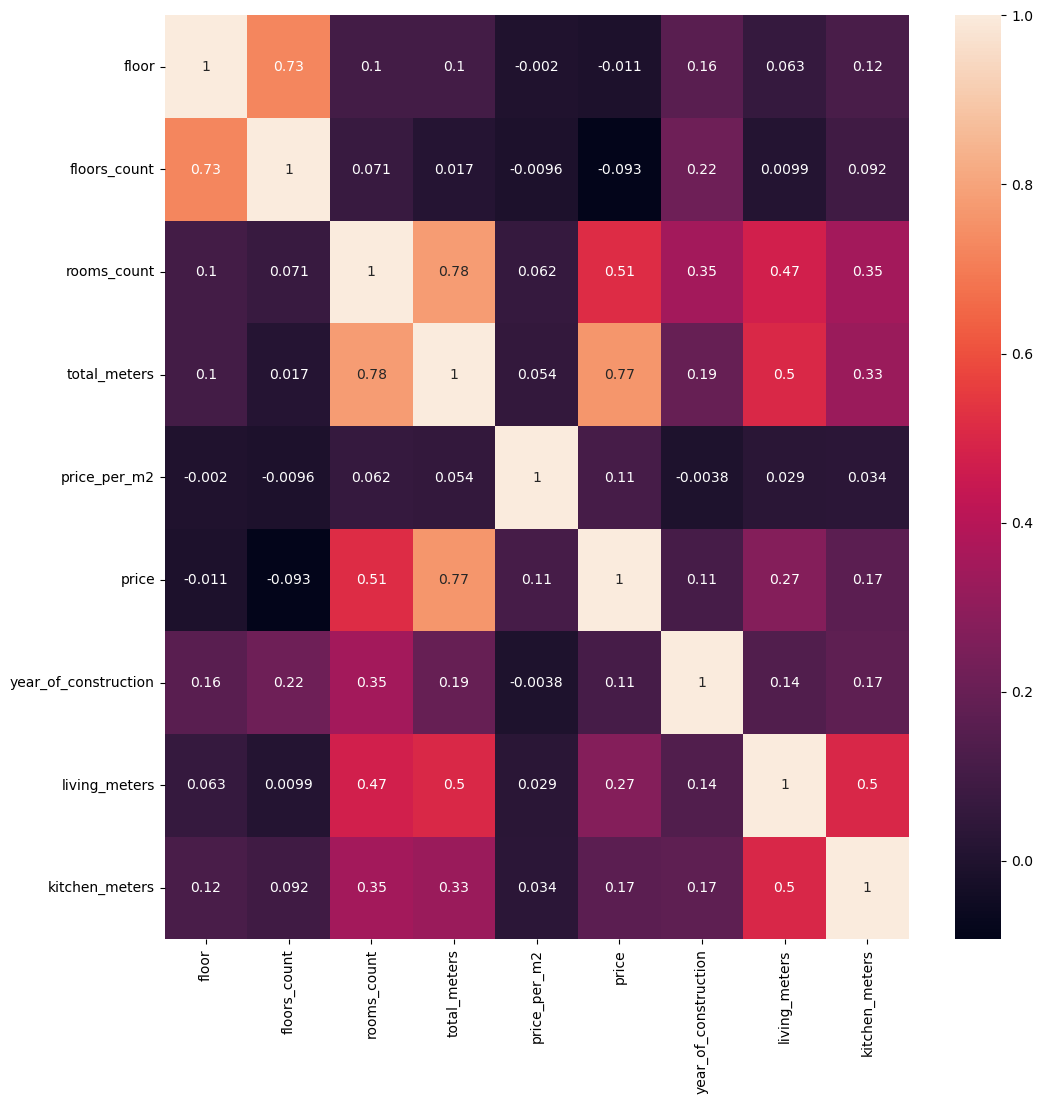

In [27]:
plt.figure(figsize = (12,12))
sns.heatmap(df_cop.drop(columns = 'address').corr(),annot = True)

In [28]:
df_cop['address']

0                                         Текстильщики Шкулева Волжская 
1                 Хорошевский Ленинградский проспект Аэропорт Прайм Парк
2                          Хамовники Усачева Спортивная Садовые кварталы
3                 Хорошевский Ленинградский проспект Аэропорт Прайм Парк
4                 Нагатино-Садовники Нагатинская набережная Коломенская 
                                      ...                               
11150                               Обручевский Островитянова Тропарёво 
11287                  Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
11303    Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
11304      Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse
11309                     Пресненский Мантулинская Выставочная City Park
Name: address, Length: 6930, dtype: object

Смотрим на nan значения

<Axes: >

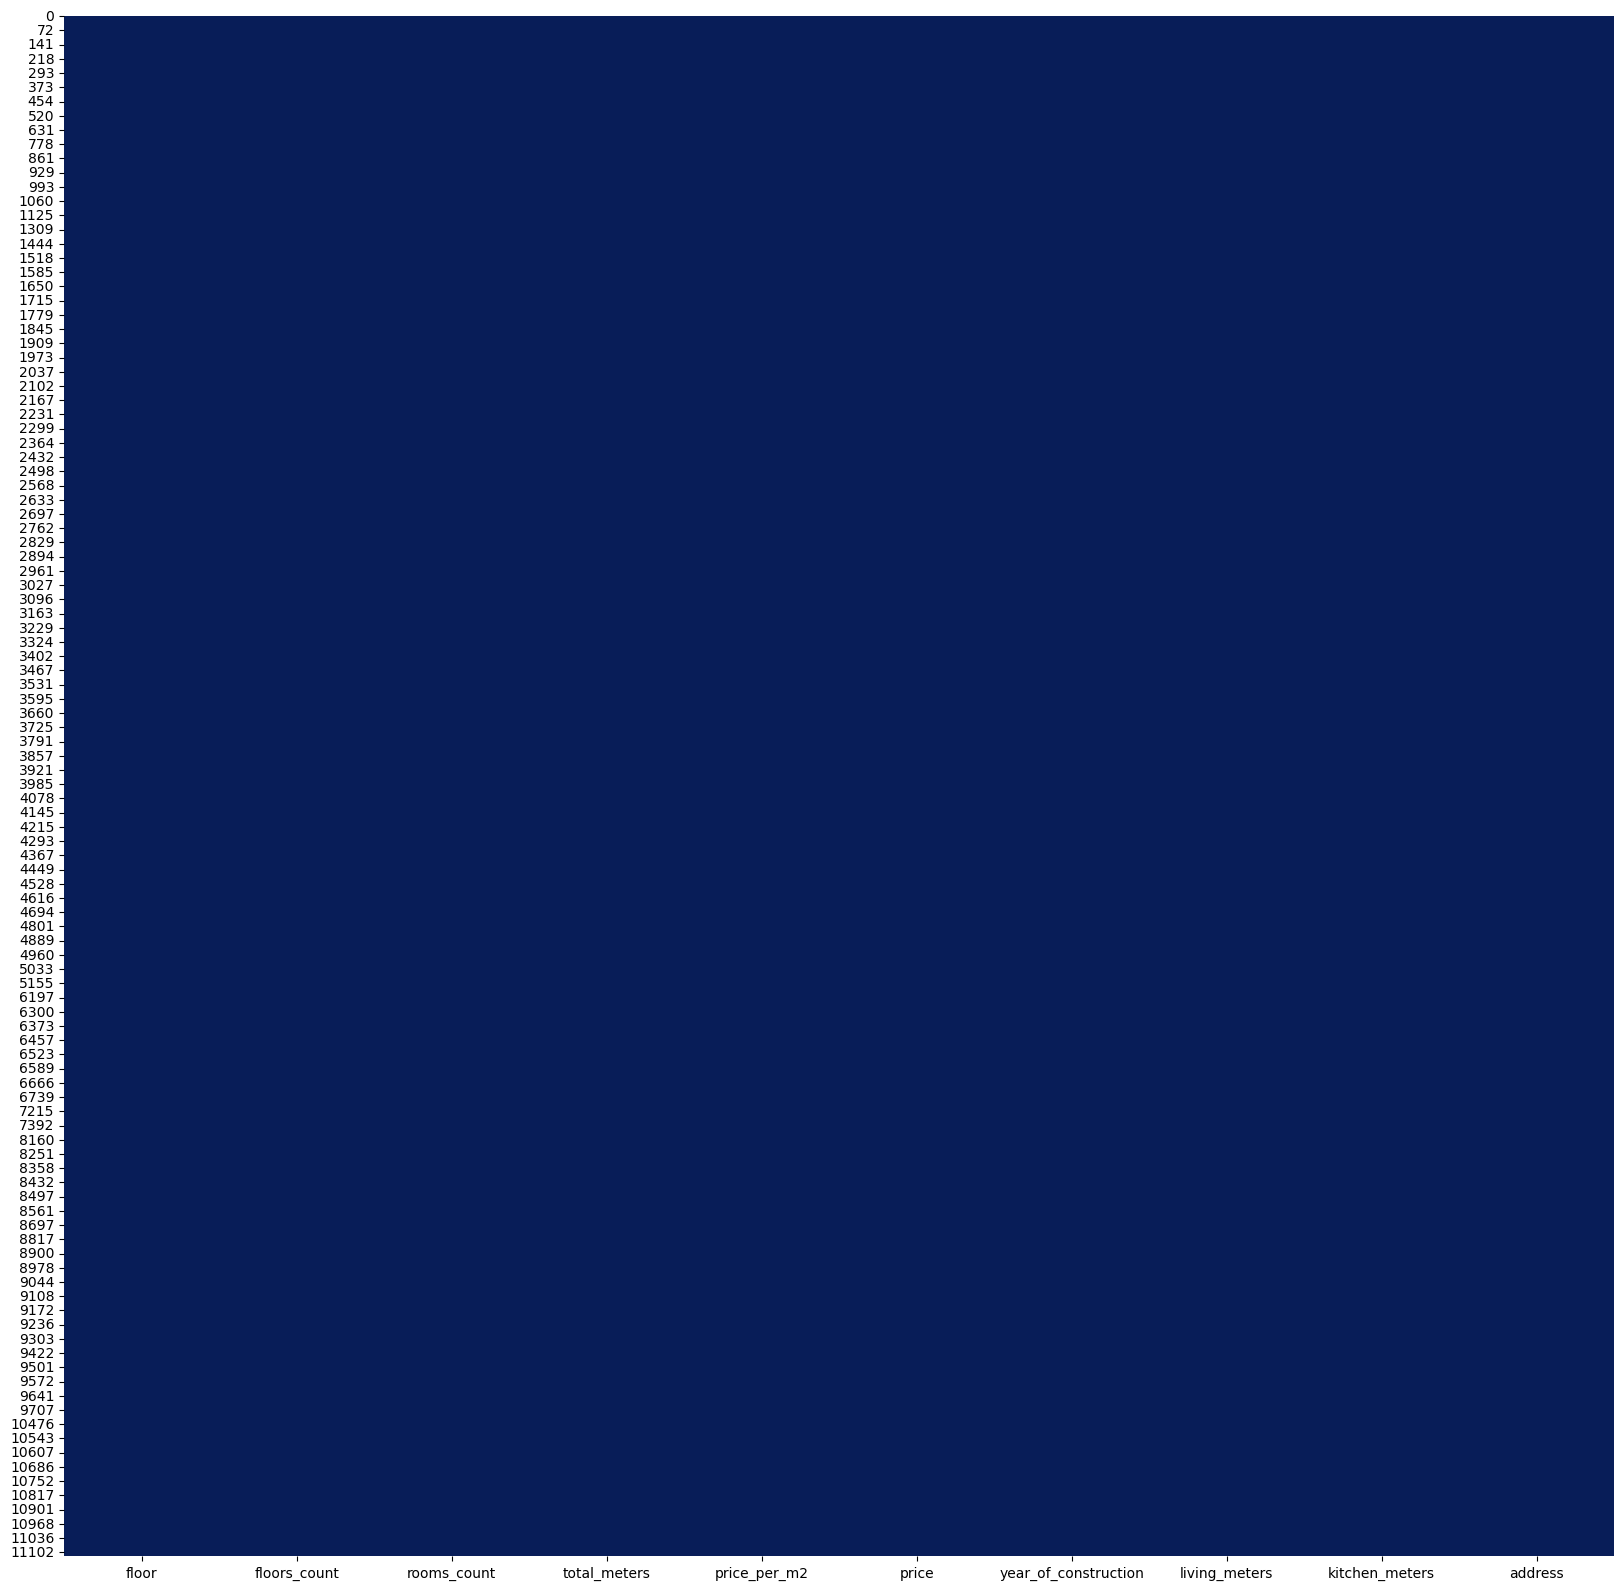

In [29]:
plt.figure(figsize = (20,20))
sns.heatmap(data = df_cop.isnull(),cmap="YlGnBu_r",cbar=False)

In [30]:
df_cop.isna().sum()/df.shape[0]*100

floor                   0.0
floors_count            0.0
rooms_count             0.0
total_meters            0.0
price_per_m2            0.0
price                   0.0
year_of_construction    0.0
living_meters           0.0
kitchen_meters          0.0
address                 0.0
dtype: float64

In [31]:
df_cop.dropna(inplace = True)
df_cop.reset_index(drop = True,inplace = True)
df_cop.head(100)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,1,5,1,12.00,291666,3500000,-1,-1.0,-1.0,Текстильщики Шкулева Волжская
1,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
2,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,Хамовники Усачева Спортивная Садовые кварталы
3,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
4,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
5,6,13,1,71.10,983122,69900000,2019,37.1,12.8,Хамовники Усачева Спортивная Садовые кварталы
6,7,9,1,18.00,382000,6876000,-1,-1.0,-1.0,Аэропорт Большой Коптевский проезд Красный Балтиец
7,33,36,1,75.00,626666,47000000,2020,35.0,20.0,Хорошево-Мневники Шелепихинская набережная Шелепиха Сердце Столицы
8,9,17,1,37.20,147072,5471080,2022,-1.0,-1.0,Лухмановская
9,6,41,1,41.00,724390,29700000,2022,24.0,6.0,Хорошевский Ленинградский проспект Аэропорт Прайм Парк


In [32]:
df_cop

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,1,5,1,12.00,291666,3500000,-1,-1.0,-1.0,Текстильщики Шкулева Волжская
1,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
2,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,Хамовники Усачева Спортивная Садовые кварталы
3,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
4,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
...,...,...,...,...,...,...,...,...,...,...
6925,11,22,4,119.40,293132,35000000,2004,67.3,17.8,Обручевский Островитянова Тропарёво
6926,11,17,4,172.63,434455,74999999,2008,-1.0,-1.0,Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
6927,37,78,2,73.00,602739,44000000,2020,-1.0,-1.0,Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
6928,3,5,2,42.00,892142,37470000,2021,-1.0,-1.0,Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse


In [33]:
print('floor')
print(np.sort(df_cop['floor'].unique()))
print('floors_count')
print(np.sort(df_cop['floors_count'].unique()))
print('rooms_count')
print(np.sort(df_cop['rooms_count'].unique()))
print('total_meters')
print(np.sort(df_cop['total_meters'].unique()))
print('price_per_m2')
print(np.sort(df_cop['price_per_m2'].unique()))
print('year_of_construction')
print(np.sort(df_cop['year_of_construction'].unique()))
print('living_meters')
print(np.sort(df_cop['living_meters'].unique()))
print('kitchen_meters')
print(np.sort(df_cop['kitchen_meters'].unique()))

floor
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 61 62 63 66 67 75 78 79 92]
floors_count
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 63 64 65 67 69 73 75 76 77 78 79
 82 85 86 87 95]
rooms_count
[-1  1  2  3  4  5]
total_meters
[-1.0000e+00  1.0100e-01  1.2000e-01  7.5000e+00  8.7000e+00  1.0000e+01
  1.0300e+01  1.0400e+01  1.0500e+01  1.0600e+01  1.1000e+01  1.1100e+01
  1.1400e+01  1.1500e+01  1.1600e+01  1.1700e+01  1.1800e+01  1.1900e+01
  1.2000e+01  1.2100e+01  1.2300e+01  1.2400e+01  1.2500e+01  1.2600e+01
  1.2700e+01  1.2800e+01  1.3000e+01  1.3100e+01  1.3300e+01  1.3400e+01
  1.3500e+01  1.3600e+01  1.3700e+01  1.3800e+01  1.3900e+01  1.4000e+01
  1.4100e+01  1.4200e+01  1.4300e+01  1.4400e+01  1.45

# Выбросы

In [34]:
def quantiles(arr):
    work_val = arr.copy()
    Q1 = work_val.quantile(0.25)#np.percentile(work_val, 25, method= 'midpoint')
    Q3 = work_val.quantile(0.75)#np.percentile(work_val, 75, method= 'midpoint')
    IQR = Q3-Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR
    return upper,lower

def anti_emmi(df):
    if df.select_dtypes(include = [np.number]).all().any():
        for col in df.select_dtypes(include = [np.number]).columns:
            
            up,low = quantiles(df[col])
            df = df[~(df[col] < low) | (df[col] > up)]

    return df.reset_index(drop=True)

In [35]:
df_cop = anti_emmi(df_cop)
df_cop

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
1,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,Хамовники Усачева Спортивная Садовые кварталы
2,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
3,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
4,6,13,1,71.10,983122,69900000,2019,37.1,12.8,Хамовники Усачева Спортивная Садовые кварталы
...,...,...,...,...,...,...,...,...,...,...
6230,11,22,4,119.40,293132,35000000,2004,67.3,17.8,Обручевский Островитянова Тропарёво
6231,11,17,4,172.63,434455,74999999,2008,-1.0,-1.0,Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
6232,37,78,2,73.00,602739,44000000,2020,-1.0,-1.0,Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
6233,3,5,2,42.00,892142,37470000,2021,-1.0,-1.0,Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse


In [36]:
df_cop.columns

Index(['floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_m2',
       'price', 'year_of_construction', 'living_meters', 'kitchen_meters',
       'address'],
      dtype='object')

In [37]:
for col in df_cop.drop(columns = 'address').columns:
    print(col)
    print(df_cop[df_cop[col]<0][col].unique())

floor
[-1]
floors_count
[-1]
rooms_count
[-1]
total_meters
[]
price_per_m2
[]
price
[]
year_of_construction
[]
living_meters
[-1.]
kitchen_meters
[-1.]


Если значение = -1 (тоесть отсутствует) оно заменяется на среднее по колонке

In [38]:
# for col in df_cop.drop(columns = ['address','year_of_construction']).columns:
#     df_cop = df_cop.drop(df_cop[df_cop[col] == -1].index)

In [39]:
df_cop

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,17,41,1,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
1,5,14,1,61.97,919799,57000000,2022,-1.0,-1.0,Хамовники Усачева Спортивная Садовые кварталы
2,9,41,1,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
3,12,17,1,47.60,324579,15450000,2019,-1.0,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
4,6,13,1,71.10,983122,69900000,2019,37.1,12.8,Хамовники Усачева Спортивная Садовые кварталы
...,...,...,...,...,...,...,...,...,...,...
6230,11,22,4,119.40,293132,35000000,2004,67.3,17.8,Обручевский Островитянова Тропарёво
6231,11,17,4,172.63,434455,74999999,2008,-1.0,-1.0,Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
6232,37,78,2,73.00,602739,44000000,2020,-1.0,-1.0,Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
6233,3,5,2,42.00,892142,37470000,2021,-1.0,-1.0,Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse


In [40]:
def meen_yer(year):
    return round(df_cop[(df_cop['year_of_construction'] == year) & (df_cop[col] != -1)][col].mean(),1)

In [41]:
for col in df_cop.columns:
    df_cop.loc[df_cop[col] == -1,col] = df_cop.loc[df_cop[col] == -1,'year_of_construction'].apply(meen_yer)

In [163]:
def meen_room(num):
    return round(df_cop[(df_cop['rooms_count'] == num)][col].mean(),2)

In [166]:
col = 'kitchen_meters'
kit_met = df_cop['rooms_count'].apply(meen_room)

In [167]:
kit_met

0        9.58
1        9.58
2        9.58
3        9.58
4        9.58
        ...  
6229    17.39
6230    17.39
6231    11.00
6232    11.00
6233    14.62
Name: rooms_count, Length: 6234, dtype: float64

In [42]:
df_cop

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,17.0,41.0,1.0,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
1,5.0,14.0,1.0,61.97,919799,57000000,2022,34.5,13.1,Хамовники Усачева Спортивная Садовые кварталы
2,9.0,41.0,1.0,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
3,12.0,17.0,1.0,47.60,324579,15450000,2019,57.4,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
4,6.0,13.0,1.0,71.10,983122,69900000,2019,37.1,12.8,Хамовники Усачева Спортивная Садовые кварталы
...,...,...,...,...,...,...,...,...,...,...
6230,11.0,22.0,4.0,119.40,293132,35000000,2004,67.3,17.8,Обручевский Островитянова Тропарёво
6231,11.0,17.0,4.0,172.63,434455,74999999,2008,99.2,17.5,Хорошевский проезд Березовой Рощи ЦСКА Гранд-парк
6232,37.0,78.0,2.0,73.00,602739,44000000,2020,42.7,15.4,Пресненский 1-й Красногвардейский проезд Тестовская NEVA TOWERS
6233,3.0,5.0,2.0,42.00,892142,37470000,2021,44.3,14.2,Замоскворечье Озерковская набережная Новокузнецкая Bogenhouse


In [43]:
df_cop.describe()

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters
count,6235.000000,6235.000000,6234.000000,6235.000000,6.235000e+03,6.235000e+03,6235.000000,6235.000000,6235.000000
mean,9.179487,17.416327,2.998669,107.561481,5.280821e+05,7.036006e+07,2000.273617,59.955028,14.333152
std,8.590334,12.345997,1.446861,80.224464,2.283440e+06,1.044957e+08,28.308900,43.015647,8.033286
min,1.000000,2.000000,1.000000,0.101000,5.971800e+04,2.000000e+06,1902.000000,3.000000,1.000000
25%,3.000000,9.000000,2.000000,44.000000,2.550250e+05,1.170000e+07,1996.000000,29.200000,9.000000
50%,6.000000,15.000000,3.000000,86.000000,3.706290e+05,3.100000e+07,2012.000000,46.300000,13.500000
75%,12.000000,23.000000,4.000000,150.000000,6.008325e+05,8.200000e+07,2020.000000,85.000000,17.500000
max,92.000000,95.000000,5.000000,885.000000,1.782178e+08,1.650000e+09,2024.000000,680.000000,99.000000


In [44]:
# df_cop = df_cop.drop(df_cop[df_cop['total_meters']<13].index)
# df_cop.describe()

<Axes: >

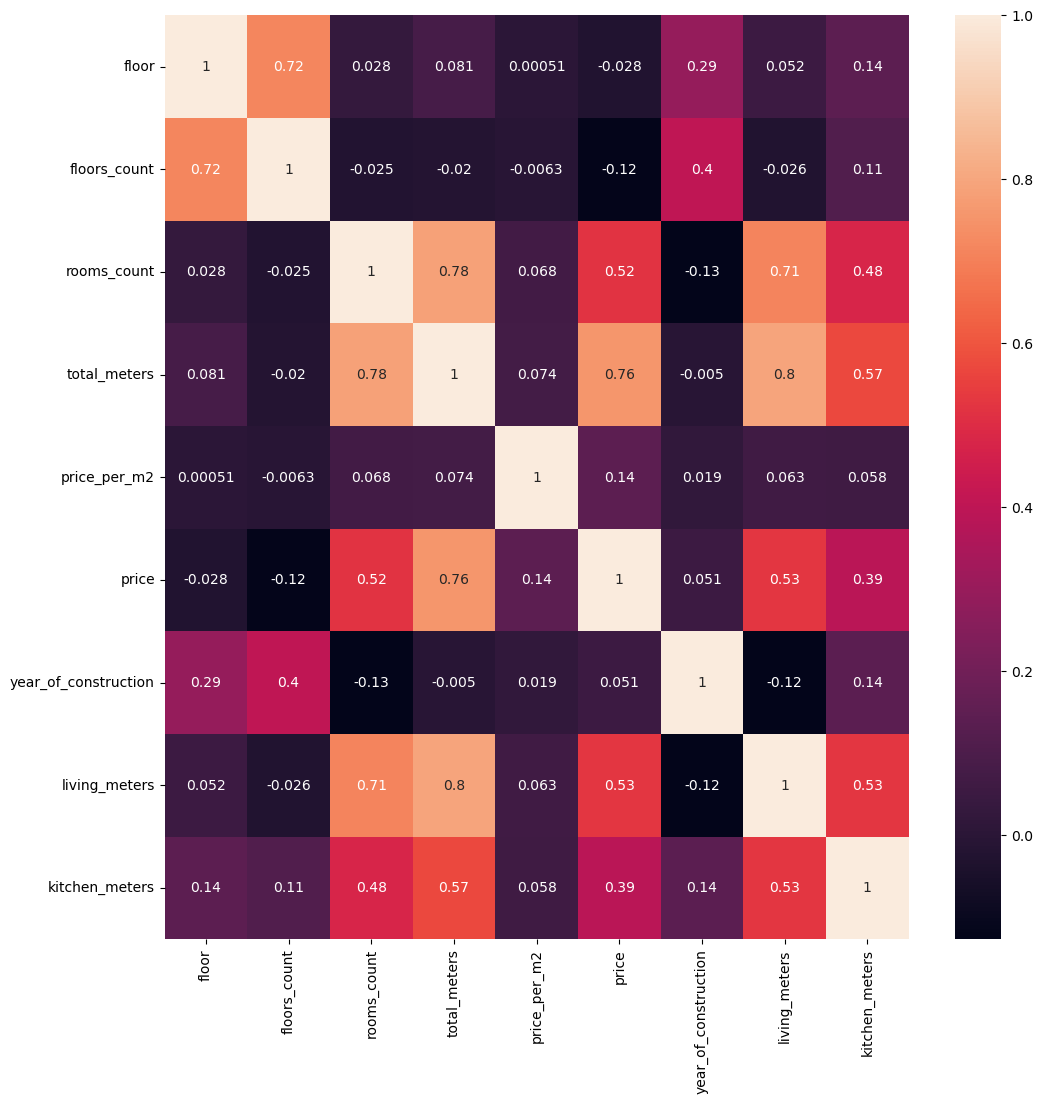

In [45]:
plt.figure(figsize = (12,12))
sns.heatmap(df_cop.drop(columns = 'address').corr(),annot = True)

In [46]:
df_cop.shape

(6235, 10)

In [47]:
for col in df_cop.drop(columns = 'address').columns:
    print(col)
    print(df_cop[df_cop[col]<0][col].unique())

floor
[]
floors_count
[]
rooms_count
[]
total_meters
[]
price_per_m2
[]
price
[]
year_of_construction
[]
living_meters
[]
kitchen_meters
[]


In [48]:
df_cop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6235 entries, 0 to 6234
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   floor                 6235 non-null   float64
 1   floors_count          6235 non-null   float64
 2   rooms_count           6234 non-null   float64
 3   total_meters          6235 non-null   float64
 4   price_per_m2          6235 non-null   int64  
 5   price                 6235 non-null   int64  
 6   year_of_construction  6235 non-null   int64  
 7   living_meters         6235 non-null   float64
 8   kitchen_meters        6235 non-null   float64
 9   address               6235 non-null   object 
dtypes: float64(6), int64(3), object(1)
memory usage: 487.2+ KB


In [49]:
df_cop.dropna(inplace = True)
df_cop.reset_index(drop = True,inplace = True)
df_cop.head(100)

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,address
0,17.0,41.0,1.0,40.40,618811,25000000,2021,15.2,9.1,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
1,5.0,14.0,1.0,61.97,919799,57000000,2022,34.5,13.1,Хамовники Усачева Спортивная Садовые кварталы
2,9.0,41.0,1.0,40.50,617283,25000000,2022,17.3,9.3,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
3,12.0,17.0,1.0,47.60,324579,15450000,2019,57.4,10.0,Нагатино-Садовники Нагатинская набережная Коломенская
4,6.0,13.0,1.0,71.10,983122,69900000,2019,37.1,12.8,Хамовники Усачева Спортивная Садовые кварталы
5,33.0,36.0,1.0,75.00,626666,47000000,2020,35.0,20.0,Хорошево-Мневники Шелепихинская набережная Шелепиха Сердце Столицы
6,9.0,17.0,1.0,37.20,147072,5471080,2022,34.5,13.1,Лухмановская
7,6.0,41.0,1.0,41.00,724390,29700000,2022,24.0,6.0,Хорошевский Ленинградский проспект Аэропорт Прайм Парк
8,16.0,21.0,1.0,48.00,602708,28930000,2015,66.0,7.0,Раменки Мосфильмовская Раменки Мосфильмовский
9,5.0,9.0,1.0,32.00,404687,12950000,1963,22.0,6.0,Зюзино Малая Юшуньская Каховская


<Axes: >

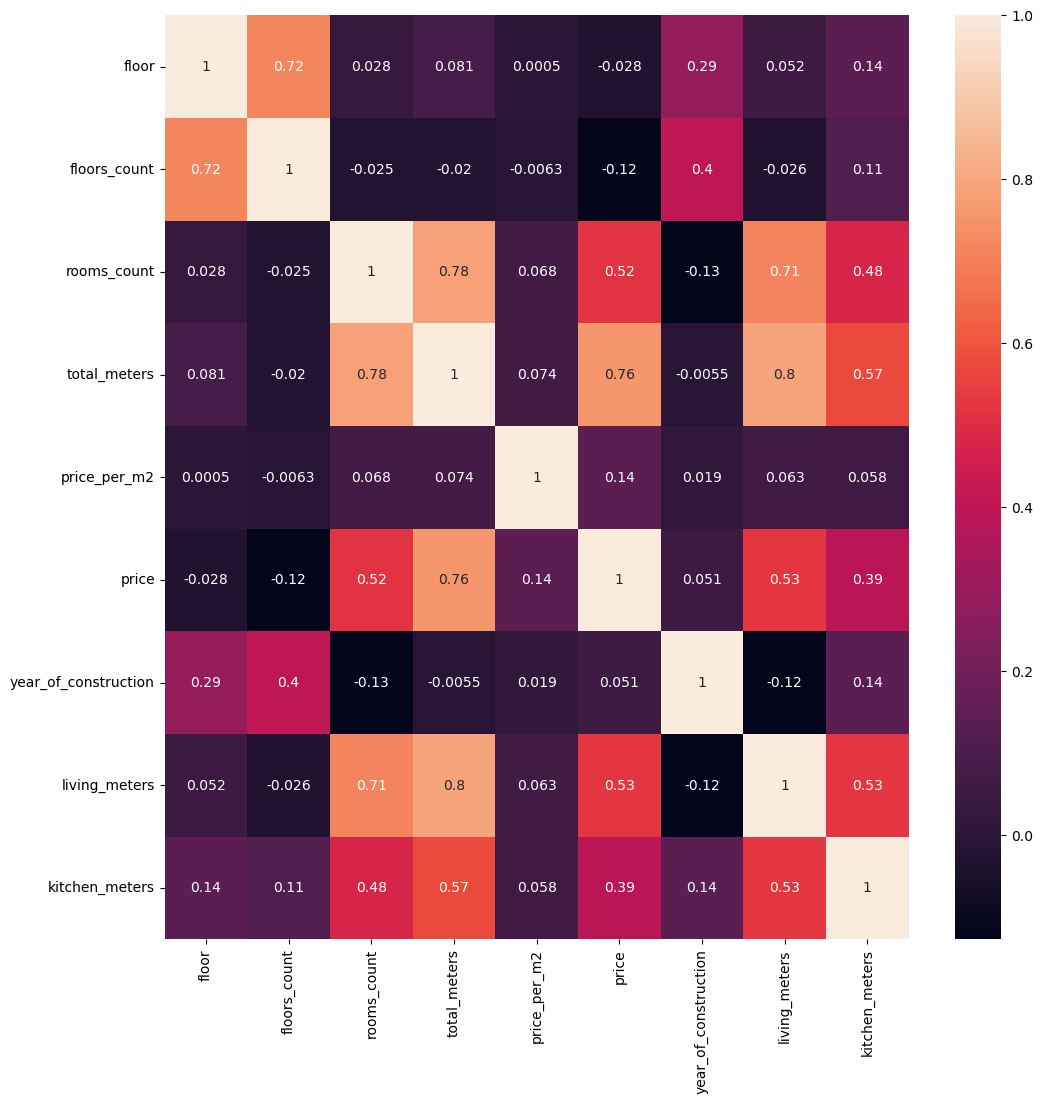

In [50]:
plt.figure(figsize = (12,12))
sns.heatmap(df_cop.drop(columns = 'address').corr(),annot = True)

In [51]:
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    #if len(tokens) > 2:
    return tokens
    #return None
    
df_cop['address'] = df_cop['address'].apply(lemmatize)

In [52]:
def concat(text):
    text= ' '.join(text)
    return text

df_cop['address'] = df_cop['address'].apply(concat)

In [53]:
df_cop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   floor                 6234 non-null   float64
 1   floors_count          6234 non-null   float64
 2   rooms_count           6234 non-null   float64
 3   total_meters          6234 non-null   float64
 4   price_per_m2          6234 non-null   int64  
 5   price                 6234 non-null   int64  
 6   year_of_construction  6234 non-null   int64  
 7   living_meters         6234 non-null   float64
 8   kitchen_meters        6234 non-null   float64
 9   address               6234 non-null   object 
dtypes: float64(6), int64(3), object(1)
memory usage: 487.2+ KB


In [54]:
# X_plus = enc.transform(df_cop['address']).toarray()

# Модели

<Axes: >

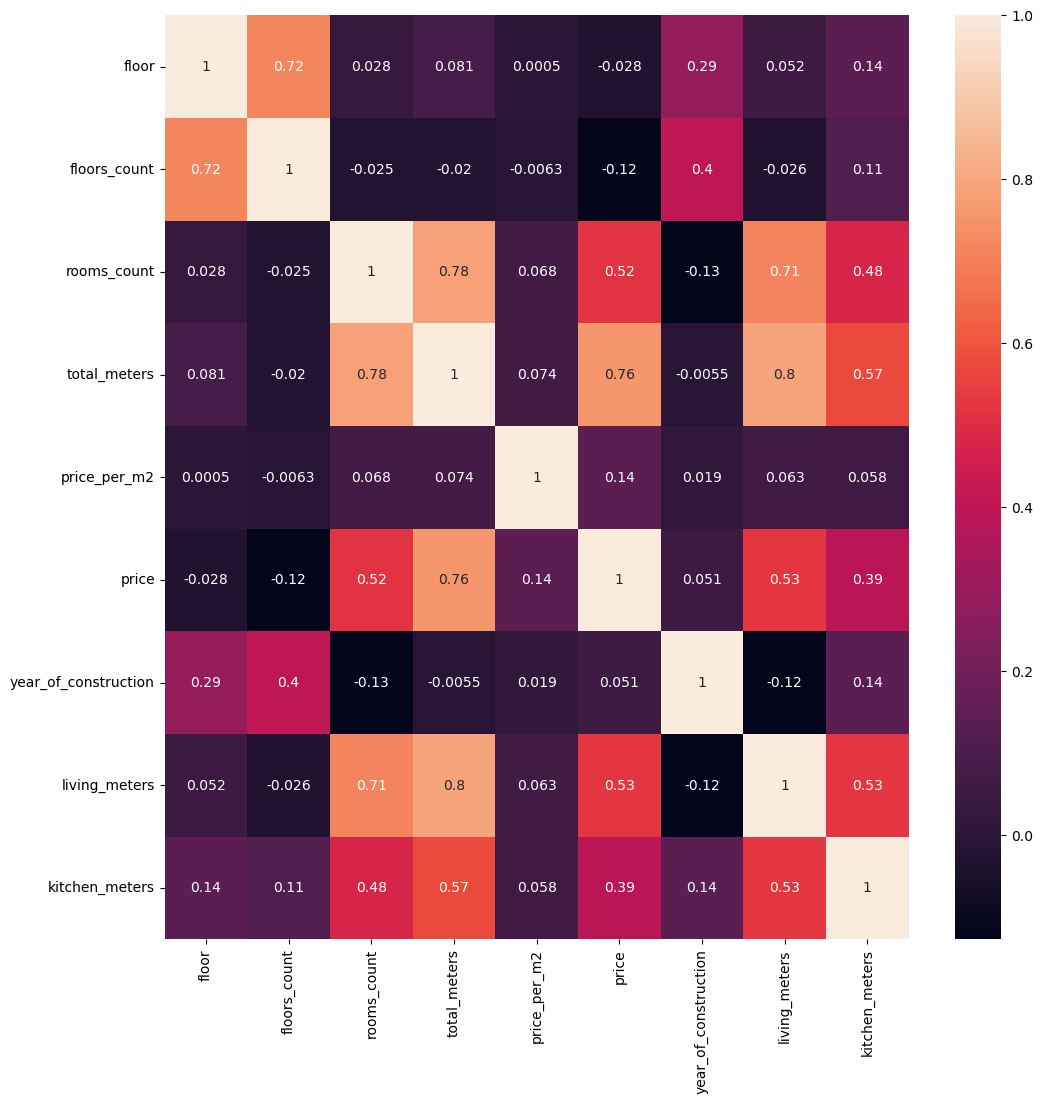

In [55]:
plt.figure(figsize = (12,12))
sns.heatmap(df_cop.drop(columns = 'address').corr(),annot = True)

In [56]:
df_cop.columns

Index(['floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_m2',
       'price', 'year_of_construction', 'living_meters', 'kitchen_meters',
       'address'],
      dtype='object')

In [133]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2','year_of_construction','living_meters','kitchen_meters'])
y = df_cop['year_of_construction']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [135]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [3])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 25 candidates, totalling 50 fits
0:	learn: 17.5383611	total: 20.5ms	remaining: 20.4s
1:	learn: 16.8849966	total: 45.9ms	remaining: 22.9s
2:	learn: 16.2089908	total: 64.7ms	remaining: 21.5s
3:	learn: 15.7425212	total: 83.3ms	remaining: 20.8s
4:	learn: 15.3555011	total: 102ms	remaining: 20.3s
5:	learn: 15.0098257	total: 121ms	remaining: 20s
6:	learn: 14.7255226	total: 139ms	remaining: 19.7s
7:	learn: 14.4256647	total: 157ms	remaining: 19.5s
8:	learn: 14.2292093	total: 171ms	remaining: 18.8s
9:	learn: 14.0331893	total: 189ms	remaining: 18.7s
10:	learn: 13.8766210	total: 202ms	remaining: 18.2s
11:	learn: 13.6901069	total: 221ms	remaining: 18.2s
12:	learn: 13.5015153	total: 247ms	remaining: 18.7s
13:	learn: 13.3478121	total: 267ms	remaining: 18.8s
14:	learn: 13.2189543	total: 285ms	remaining: 18.7s
15:	learn: 13.1148721	total: 303ms	remaining: 18.7s
16:	learn: 13.0098554	total: 322ms	remaining: 18.6s
17:	learn: 12.8550067	total: 341ms	remaining: 18.6s
18:	learn: 

159:	learn: 10.3460116	total: 3.25s	remaining: 17.1s
160:	learn: 10.3365266	total: 3.27s	remaining: 17.1s
161:	learn: 10.3350117	total: 3.29s	remaining: 17s
162:	learn: 10.3332715	total: 3.31s	remaining: 17s
163:	learn: 10.3313239	total: 3.33s	remaining: 17s
164:	learn: 10.3284420	total: 3.35s	remaining: 16.9s
165:	learn: 10.3221849	total: 3.36s	remaining: 16.9s
166:	learn: 10.3207585	total: 3.38s	remaining: 16.9s
167:	learn: 10.3160554	total: 3.4s	remaining: 16.8s
168:	learn: 10.3148159	total: 3.42s	remaining: 16.8s
169:	learn: 10.3120291	total: 3.44s	remaining: 16.8s
170:	learn: 10.3115516	total: 3.46s	remaining: 16.8s
171:	learn: 10.3082300	total: 3.48s	remaining: 16.8s
172:	learn: 10.2782925	total: 3.5s	remaining: 16.7s
173:	learn: 10.2710975	total: 3.52s	remaining: 16.7s
174:	learn: 10.2704699	total: 3.54s	remaining: 16.7s
175:	learn: 10.2695457	total: 3.56s	remaining: 16.6s
176:	learn: 10.2689813	total: 3.58s	remaining: 16.6s
177:	learn: 10.2685134	total: 3.59s	remaining: 16.6s
1

320:	learn: 9.8150700	total: 6.49s	remaining: 13.7s
321:	learn: 9.8054059	total: 6.52s	remaining: 13.7s
322:	learn: 9.8021523	total: 6.53s	remaining: 13.7s
323:	learn: 9.8020393	total: 6.55s	remaining: 13.7s
324:	learn: 9.7991189	total: 6.58s	remaining: 13.7s
325:	learn: 9.7980733	total: 6.6s	remaining: 13.6s
326:	learn: 9.7966660	total: 6.62s	remaining: 13.6s
327:	learn: 9.7946036	total: 6.64s	remaining: 13.6s
328:	learn: 9.7940569	total: 6.66s	remaining: 13.6s
329:	learn: 9.7926990	total: 6.68s	remaining: 13.6s
330:	learn: 9.7905038	total: 6.7s	remaining: 13.5s
331:	learn: 9.7886979	total: 6.73s	remaining: 13.5s
332:	learn: 9.7881746	total: 6.75s	remaining: 13.5s
333:	learn: 9.7880630	total: 6.78s	remaining: 13.5s
334:	learn: 9.7841714	total: 6.8s	remaining: 13.5s
335:	learn: 9.7832393	total: 6.83s	remaining: 13.5s
336:	learn: 9.7747849	total: 6.85s	remaining: 13.5s
337:	learn: 9.7740014	total: 6.88s	remaining: 13.5s
338:	learn: 9.7722928	total: 6.9s	remaining: 13.5s
339:	learn: 9.76

490:	learn: 9.5039343	total: 10s	remaining: 10.4s
491:	learn: 9.5024993	total: 10.1s	remaining: 10.4s
492:	learn: 9.5023411	total: 10.1s	remaining: 10.4s
493:	learn: 9.5016837	total: 10.1s	remaining: 10.3s
494:	learn: 9.5016363	total: 10.1s	remaining: 10.3s
495:	learn: 9.5015729	total: 10.1s	remaining: 10.3s
496:	learn: 9.5015260	total: 10.2s	remaining: 10.3s
497:	learn: 9.5010737	total: 10.2s	remaining: 10.3s
498:	learn: 9.4930934	total: 10.2s	remaining: 10.2s
499:	learn: 9.4929278	total: 10.2s	remaining: 10.2s
500:	learn: 9.4927381	total: 10.2s	remaining: 10.2s
501:	learn: 9.4917233	total: 10.2s	remaining: 10.2s
502:	learn: 9.4896341	total: 10.3s	remaining: 10.1s
503:	learn: 9.4891740	total: 10.3s	remaining: 10.1s
504:	learn: 9.4862963	total: 10.3s	remaining: 10.1s
505:	learn: 9.4862635	total: 10.3s	remaining: 10.1s
506:	learn: 9.4859521	total: 10.3s	remaining: 10.1s
507:	learn: 9.4857635	total: 10.4s	remaining: 10s
508:	learn: 9.4857359	total: 10.4s	remaining: 10s
509:	learn: 9.4856

659:	learn: 9.2664524	total: 13.4s	remaining: 6.88s
660:	learn: 9.2662061	total: 13.4s	remaining: 6.86s
661:	learn: 9.2660502	total: 13.4s	remaining: 6.84s
662:	learn: 9.2658879	total: 13.4s	remaining: 6.82s
663:	learn: 9.2658465	total: 13.4s	remaining: 6.8s
664:	learn: 9.2656104	total: 13.5s	remaining: 6.79s
665:	learn: 9.2655181	total: 13.5s	remaining: 6.77s
666:	learn: 9.2652543	total: 13.5s	remaining: 6.75s
667:	learn: 9.2652328	total: 13.6s	remaining: 6.73s
668:	learn: 9.2651614	total: 13.6s	remaining: 6.72s
669:	learn: 9.2650744	total: 13.6s	remaining: 6.7s
670:	learn: 9.2579437	total: 13.6s	remaining: 6.68s
671:	learn: 9.2577913	total: 13.6s	remaining: 6.66s
672:	learn: 9.2574112	total: 13.7s	remaining: 6.64s
673:	learn: 9.2570146	total: 13.7s	remaining: 6.62s
674:	learn: 9.2567188	total: 13.7s	remaining: 6.6s
675:	learn: 9.2557207	total: 13.7s	remaining: 6.58s
676:	learn: 9.2545063	total: 13.8s	remaining: 6.56s
677:	learn: 9.2532738	total: 13.8s	remaining: 6.54s
678:	learn: 9.2

826:	learn: 9.1283761	total: 17s	remaining: 3.56s
827:	learn: 9.1280021	total: 17.1s	remaining: 3.54s
828:	learn: 9.1279132	total: 17.1s	remaining: 3.52s
829:	learn: 9.1270241	total: 17.1s	remaining: 3.51s
830:	learn: 9.1270172	total: 17.1s	remaining: 3.49s
831:	learn: 9.1265023	total: 17.2s	remaining: 3.47s
832:	learn: 9.1260880	total: 17.2s	remaining: 3.45s
833:	learn: 9.1260696	total: 17.2s	remaining: 3.43s
834:	learn: 9.1259866	total: 17.3s	remaining: 3.41s
835:	learn: 9.1257848	total: 17.3s	remaining: 3.39s
836:	learn: 9.1257608	total: 17.3s	remaining: 3.37s
837:	learn: 9.1256210	total: 17.3s	remaining: 3.35s
838:	learn: 9.1254008	total: 17.3s	remaining: 3.33s
839:	learn: 9.1253220	total: 17.4s	remaining: 3.31s
840:	learn: 9.1245564	total: 17.4s	remaining: 3.29s
841:	learn: 9.1243719	total: 17.4s	remaining: 3.27s
842:	learn: 9.1243143	total: 17.4s	remaining: 3.25s
843:	learn: 9.1239918	total: 17.4s	remaining: 3.22s
844:	learn: 9.1229223	total: 17.5s	remaining: 3.2s
845:	learn: 9.1

985:	learn: 9.0199126	total: 20.3s	remaining: 289ms
986:	learn: 9.0198730	total: 20.4s	remaining: 268ms
987:	learn: 9.0198526	total: 20.4s	remaining: 248ms
988:	learn: 9.0198457	total: 20.4s	remaining: 227ms
989:	learn: 9.0197710	total: 20.4s	remaining: 206ms
990:	learn: 9.0194915	total: 20.5s	remaining: 186ms
991:	learn: 9.0192813	total: 20.5s	remaining: 165ms
992:	learn: 9.0191892	total: 20.5s	remaining: 144ms
993:	learn: 9.0191624	total: 20.5s	remaining: 124ms
994:	learn: 9.0190487	total: 20.5s	remaining: 103ms
995:	learn: 9.0189476	total: 20.6s	remaining: 82.5ms
996:	learn: 9.0189406	total: 20.6s	remaining: 61.9ms
997:	learn: 9.0179989	total: 20.6s	remaining: 41.3ms
998:	learn: 9.0177618	total: 20.6s	remaining: 20.6ms
999:	learn: 9.0177456	total: 20.7s	remaining: 0us


({'depth': 7, 'learning_rate': 0.1}, 0.5031962740758266)

In [128]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=7,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [3])

0:	learn: 17.5383611	total: 19.8ms	remaining: 19.8s
1:	learn: 16.8849966	total: 45.3ms	remaining: 22.6s
2:	learn: 16.2089908	total: 64.6ms	remaining: 21.5s
3:	learn: 15.7425212	total: 83.6ms	remaining: 20.8s
4:	learn: 15.3555011	total: 102ms	remaining: 20.3s
5:	learn: 15.0098257	total: 121ms	remaining: 20s
6:	learn: 14.7255226	total: 138ms	remaining: 19.6s
7:	learn: 14.4256647	total: 156ms	remaining: 19.4s
8:	learn: 14.2292093	total: 170ms	remaining: 18.7s
9:	learn: 14.0331893	total: 187ms	remaining: 18.5s
10:	learn: 13.8766210	total: 200ms	remaining: 18s
11:	learn: 13.6901069	total: 218ms	remaining: 18s
12:	learn: 13.5015153	total: 238ms	remaining: 18.1s
13:	learn: 13.3478121	total: 261ms	remaining: 18.4s
14:	learn: 13.2189543	total: 280ms	remaining: 18.4s
15:	learn: 13.1148721	total: 297ms	remaining: 18.3s
16:	learn: 13.0098554	total: 315ms	remaining: 18.2s
17:	learn: 12.8550067	total: 334ms	remaining: 18.2s
18:	learn: 12.7775305	total: 352ms	remaining: 18.2s
19:	learn: 12.7035888	to

159:	learn: 10.3460116	total: 3.77s	remaining: 19.8s
160:	learn: 10.3365266	total: 3.8s	remaining: 19.8s
161:	learn: 10.3350117	total: 3.82s	remaining: 19.7s
162:	learn: 10.3332715	total: 3.83s	remaining: 19.7s
163:	learn: 10.3313239	total: 3.85s	remaining: 19.6s
164:	learn: 10.3284420	total: 3.87s	remaining: 19.6s
165:	learn: 10.3221849	total: 3.89s	remaining: 19.5s
166:	learn: 10.3207585	total: 3.91s	remaining: 19.5s
167:	learn: 10.3160554	total: 3.93s	remaining: 19.5s
168:	learn: 10.3148159	total: 3.95s	remaining: 19.4s
169:	learn: 10.3120291	total: 3.96s	remaining: 19.4s
170:	learn: 10.3115516	total: 3.99s	remaining: 19.3s
171:	learn: 10.3082300	total: 4s	remaining: 19.3s
172:	learn: 10.2782925	total: 4.02s	remaining: 19.2s
173:	learn: 10.2710975	total: 4.04s	remaining: 19.2s
174:	learn: 10.2704699	total: 4.06s	remaining: 19.2s
175:	learn: 10.2695457	total: 4.09s	remaining: 19.1s
176:	learn: 10.2689813	total: 4.11s	remaining: 19.1s
177:	learn: 10.2685134	total: 4.13s	remaining: 19.

323:	learn: 9.8020393	total: 7.29s	remaining: 15.2s
324:	learn: 9.7991189	total: 7.31s	remaining: 15.2s
325:	learn: 9.7980733	total: 7.33s	remaining: 15.2s
326:	learn: 9.7966660	total: 7.35s	remaining: 15.1s
327:	learn: 9.7946036	total: 7.37s	remaining: 15.1s
328:	learn: 9.7940569	total: 7.39s	remaining: 15.1s
329:	learn: 9.7926990	total: 7.41s	remaining: 15.1s
330:	learn: 9.7905038	total: 7.43s	remaining: 15s
331:	learn: 9.7886979	total: 7.45s	remaining: 15s
332:	learn: 9.7881746	total: 7.47s	remaining: 15s
333:	learn: 9.7880630	total: 7.49s	remaining: 14.9s
334:	learn: 9.7841714	total: 7.51s	remaining: 14.9s
335:	learn: 9.7832393	total: 7.53s	remaining: 14.9s
336:	learn: 9.7747849	total: 7.55s	remaining: 14.9s
337:	learn: 9.7740014	total: 7.57s	remaining: 14.8s
338:	learn: 9.7722928	total: 7.59s	remaining: 14.8s
339:	learn: 9.7621681	total: 7.61s	remaining: 14.8s
340:	learn: 9.7602919	total: 7.63s	remaining: 14.7s
341:	learn: 9.7547452	total: 7.65s	remaining: 14.7s
342:	learn: 9.7499

486:	learn: 9.5046667	total: 11.5s	remaining: 12.1s
487:	learn: 9.5046014	total: 11.5s	remaining: 12.1s
488:	learn: 9.5044831	total: 11.6s	remaining: 12.1s
489:	learn: 9.5040225	total: 11.6s	remaining: 12.1s
490:	learn: 9.5039343	total: 11.6s	remaining: 12s
491:	learn: 9.5024993	total: 11.6s	remaining: 12s
492:	learn: 9.5023411	total: 11.7s	remaining: 12s
493:	learn: 9.5016837	total: 11.7s	remaining: 12s
494:	learn: 9.5016363	total: 11.7s	remaining: 11.9s
495:	learn: 9.5015729	total: 11.7s	remaining: 11.9s
496:	learn: 9.5015260	total: 11.7s	remaining: 11.9s
497:	learn: 9.5010737	total: 11.8s	remaining: 11.9s
498:	learn: 9.4930934	total: 11.8s	remaining: 11.8s
499:	learn: 9.4929278	total: 11.8s	remaining: 11.8s
500:	learn: 9.4927381	total: 11.8s	remaining: 11.8s
501:	learn: 9.4917233	total: 11.9s	remaining: 11.8s
502:	learn: 9.4896341	total: 11.9s	remaining: 11.8s
503:	learn: 9.4891740	total: 11.9s	remaining: 11.7s
504:	learn: 9.4862963	total: 11.9s	remaining: 11.7s
505:	learn: 9.486263

654:	learn: 9.2711422	total: 15.2s	remaining: 8.02s
655:	learn: 9.2709000	total: 15.2s	remaining: 7.99s
656:	learn: 9.2707549	total: 15.3s	remaining: 7.97s
657:	learn: 9.2701315	total: 15.3s	remaining: 7.94s
658:	learn: 9.2677243	total: 15.3s	remaining: 7.92s
659:	learn: 9.2664524	total: 15.3s	remaining: 7.89s
660:	learn: 9.2662061	total: 15.3s	remaining: 7.87s
661:	learn: 9.2660502	total: 15.4s	remaining: 7.84s
662:	learn: 9.2658879	total: 15.4s	remaining: 7.82s
663:	learn: 9.2658465	total: 15.4s	remaining: 7.79s
664:	learn: 9.2656104	total: 15.4s	remaining: 7.76s
665:	learn: 9.2655181	total: 15.4s	remaining: 7.74s
666:	learn: 9.2652543	total: 15.5s	remaining: 7.71s
667:	learn: 9.2652328	total: 15.5s	remaining: 7.69s
668:	learn: 9.2651614	total: 15.5s	remaining: 7.66s
669:	learn: 9.2650744	total: 15.5s	remaining: 7.64s
670:	learn: 9.2579437	total: 15.5s	remaining: 7.62s
671:	learn: 9.2577913	total: 15.6s	remaining: 7.59s
672:	learn: 9.2574112	total: 15.6s	remaining: 7.57s
673:	learn: 

817:	learn: 9.1381606	total: 19s	remaining: 4.22s
818:	learn: 9.1381450	total: 19s	remaining: 4.2s
819:	learn: 9.1380170	total: 19s	remaining: 4.18s
820:	learn: 9.1378748	total: 19.1s	remaining: 4.15s
821:	learn: 9.1378309	total: 19.1s	remaining: 4.13s
822:	learn: 9.1377060	total: 19.1s	remaining: 4.11s
823:	learn: 9.1373917	total: 19.1s	remaining: 4.09s
824:	learn: 9.1366915	total: 19.2s	remaining: 4.06s
825:	learn: 9.1366275	total: 19.2s	remaining: 4.04s
826:	learn: 9.1283761	total: 19.2s	remaining: 4.02s
827:	learn: 9.1280021	total: 19.2s	remaining: 4s
828:	learn: 9.1279132	total: 19.3s	remaining: 3.97s
829:	learn: 9.1270241	total: 19.3s	remaining: 3.95s
830:	learn: 9.1270172	total: 19.3s	remaining: 3.93s
831:	learn: 9.1265023	total: 19.3s	remaining: 3.9s
832:	learn: 9.1260880	total: 19.4s	remaining: 3.88s
833:	learn: 9.1260696	total: 19.4s	remaining: 3.86s
834:	learn: 9.1259866	total: 19.4s	remaining: 3.83s
835:	learn: 9.1257848	total: 19.4s	remaining: 3.81s
836:	learn: 9.1257608	t

981:	learn: 9.0233796	total: 22.9s	remaining: 420ms
982:	learn: 9.0225313	total: 22.9s	remaining: 397ms
983:	learn: 9.0224299	total: 23s	remaining: 373ms
984:	learn: 9.0199157	total: 23s	remaining: 350ms
985:	learn: 9.0199126	total: 23s	remaining: 327ms
986:	learn: 9.0198730	total: 23s	remaining: 303ms
987:	learn: 9.0198526	total: 23s	remaining: 280ms
988:	learn: 9.0198457	total: 23.1s	remaining: 257ms
989:	learn: 9.0197710	total: 23.1s	remaining: 233ms
990:	learn: 9.0194915	total: 23.1s	remaining: 210ms
991:	learn: 9.0192813	total: 23.1s	remaining: 187ms
992:	learn: 9.0191892	total: 23.2s	remaining: 163ms
993:	learn: 9.0191624	total: 23.2s	remaining: 140ms
994:	learn: 9.0190487	total: 23.2s	remaining: 117ms
995:	learn: 9.0189476	total: 23.2s	remaining: 93.3ms
996:	learn: 9.0189406	total: 23.2s	remaining: 69.9ms
997:	learn: 9.0179989	total: 23.3s	remaining: 46.6ms
998:	learn: 9.0177618	total: 23.3s	remaining: 23.3ms
999:	learn: 9.0177456	total: 23.3s	remaining: 0us


In [129]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

10.045568611445733

In [130]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.5414643080730395

import joblib 
joblib.dump(fit_model_price_m2, "years(str3).joblib")

In [147]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2','living_meters','kitchen_meters'])
y = df_cop['living_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [4])
gs.best_params_, gs.best_score_

In [149]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=5,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [4])

0:	learn: 29.4110741	total: 15.9ms	remaining: 15.9s
1:	learn: 27.5006302	total: 44.9ms	remaining: 22.4s
2:	learn: 25.8990752	total: 82ms	remaining: 27.3s
3:	learn: 24.5275372	total: 101ms	remaining: 25.2s
4:	learn: 23.3951458	total: 117ms	remaining: 23.2s
5:	learn: 22.4105440	total: 129ms	remaining: 21.3s
6:	learn: 21.6377716	total: 144ms	remaining: 20.5s
7:	learn: 20.8524635	total: 158ms	remaining: 19.6s
8:	learn: 20.1250947	total: 172ms	remaining: 19s
9:	learn: 19.5540502	total: 186ms	remaining: 18.4s
10:	learn: 19.0815068	total: 200ms	remaining: 18s
11:	learn: 18.6298896	total: 213ms	remaining: 17.6s
12:	learn: 18.2377574	total: 228ms	remaining: 17.3s
13:	learn: 17.9108790	total: 246ms	remaining: 17.3s
14:	learn: 17.6305706	total: 261ms	remaining: 17.2s
15:	learn: 17.3326211	total: 276ms	remaining: 17s
16:	learn: 17.1067329	total: 290ms	remaining: 16.7s
17:	learn: 16.9559330	total: 303ms	remaining: 16.6s
18:	learn: 16.7761820	total: 317ms	remaining: 16.4s
19:	learn: 16.6603326	total

161:	learn: 14.1300995	total: 2.81s	remaining: 14.5s
162:	learn: 14.1198929	total: 2.83s	remaining: 14.5s
163:	learn: 14.1065473	total: 2.85s	remaining: 14.5s
164:	learn: 14.0910611	total: 2.87s	remaining: 14.5s
165:	learn: 14.0888820	total: 2.88s	remaining: 14.5s
166:	learn: 14.0856231	total: 2.9s	remaining: 14.5s
167:	learn: 14.0799741	total: 2.92s	remaining: 14.4s
168:	learn: 14.0688396	total: 2.93s	remaining: 14.4s
169:	learn: 14.0661658	total: 2.95s	remaining: 14.4s
170:	learn: 14.0552737	total: 2.96s	remaining: 14.4s
171:	learn: 14.0501499	total: 2.98s	remaining: 14.3s
172:	learn: 14.0469559	total: 2.99s	remaining: 14.3s
173:	learn: 14.0398367	total: 3s	remaining: 14.3s
174:	learn: 14.0260504	total: 3.02s	remaining: 14.2s
175:	learn: 14.0243154	total: 3.03s	remaining: 14.2s
176:	learn: 14.0153995	total: 3.05s	remaining: 14.2s
177:	learn: 14.0105862	total: 3.07s	remaining: 14.2s
178:	learn: 14.0045075	total: 3.08s	remaining: 14.1s
179:	learn: 13.9880951	total: 3.1s	remaining: 14.1

320:	learn: 13.4213917	total: 5.38s	remaining: 11.4s
321:	learn: 13.4209187	total: 5.4s	remaining: 11.4s
322:	learn: 13.4139107	total: 5.42s	remaining: 11.4s
323:	learn: 13.4110324	total: 5.43s	remaining: 11.3s
324:	learn: 13.4101086	total: 5.45s	remaining: 11.3s
325:	learn: 13.4082086	total: 5.46s	remaining: 11.3s
326:	learn: 13.4070216	total: 5.48s	remaining: 11.3s
327:	learn: 13.4052541	total: 5.49s	remaining: 11.3s
328:	learn: 13.4009789	total: 5.51s	remaining: 11.2s
329:	learn: 13.3938568	total: 5.52s	remaining: 11.2s
330:	learn: 13.3894076	total: 5.54s	remaining: 11.2s
331:	learn: 13.3868528	total: 5.55s	remaining: 11.2s
332:	learn: 13.3837266	total: 5.56s	remaining: 11.1s
333:	learn: 13.3795647	total: 5.58s	remaining: 11.1s
334:	learn: 13.3742502	total: 5.59s	remaining: 11.1s
335:	learn: 13.3712427	total: 5.61s	remaining: 11.1s
336:	learn: 13.3704152	total: 5.63s	remaining: 11.1s
337:	learn: 13.3688259	total: 5.65s	remaining: 11.1s
338:	learn: 13.3676774	total: 5.67s	remaining: 

486:	learn: 12.9198982	total: 7.78s	remaining: 8.19s
487:	learn: 12.9178009	total: 7.79s	remaining: 8.18s
488:	learn: 12.9173430	total: 7.8s	remaining: 8.16s
489:	learn: 12.9124047	total: 7.82s	remaining: 8.14s
490:	learn: 12.9106643	total: 7.83s	remaining: 8.12s
491:	learn: 12.9090955	total: 7.84s	remaining: 8.1s
492:	learn: 12.9043462	total: 7.86s	remaining: 8.08s
493:	learn: 12.9030861	total: 7.87s	remaining: 8.06s
494:	learn: 12.8993707	total: 7.89s	remaining: 8.04s
495:	learn: 12.8978863	total: 7.9s	remaining: 8.03s
496:	learn: 12.8955927	total: 7.91s	remaining: 8.01s
497:	learn: 12.8866794	total: 7.93s	remaining: 7.99s
498:	learn: 12.8850379	total: 7.94s	remaining: 7.97s
499:	learn: 12.8827002	total: 7.95s	remaining: 7.95s
500:	learn: 12.8804895	total: 7.97s	remaining: 7.93s
501:	learn: 12.8796927	total: 7.98s	remaining: 7.92s
502:	learn: 12.8772496	total: 8s	remaining: 7.9s
503:	learn: 12.8728119	total: 8.01s	remaining: 7.88s
504:	learn: 12.8725783	total: 8.03s	remaining: 7.87s


652:	learn: 12.5343018	total: 10.4s	remaining: 5.51s
653:	learn: 12.5332377	total: 10.4s	remaining: 5.5s
654:	learn: 12.5303152	total: 10.4s	remaining: 5.48s
655:	learn: 12.5288384	total: 10.4s	remaining: 5.46s
656:	learn: 12.5258888	total: 10.4s	remaining: 5.45s
657:	learn: 12.5237425	total: 10.5s	remaining: 5.43s
658:	learn: 12.5235935	total: 10.5s	remaining: 5.42s
659:	learn: 12.5201124	total: 10.5s	remaining: 5.4s
660:	learn: 12.5192743	total: 10.5s	remaining: 5.38s
661:	learn: 12.5187180	total: 10.5s	remaining: 5.37s
662:	learn: 12.5170721	total: 10.5s	remaining: 5.35s
663:	learn: 12.5140898	total: 10.5s	remaining: 5.34s
664:	learn: 12.5131023	total: 10.6s	remaining: 5.32s
665:	learn: 12.5119644	total: 10.6s	remaining: 5.3s
666:	learn: 12.5118013	total: 10.6s	remaining: 5.29s
667:	learn: 12.5110113	total: 10.6s	remaining: 5.27s
668:	learn: 12.5105536	total: 10.6s	remaining: 5.26s
669:	learn: 12.5100256	total: 10.6s	remaining: 5.24s
670:	learn: 12.5081210	total: 10.7s	remaining: 5.

810:	learn: 12.3337141	total: 12.7s	remaining: 2.96s
811:	learn: 12.3295127	total: 12.7s	remaining: 2.95s
812:	learn: 12.3286653	total: 12.8s	remaining: 2.93s
813:	learn: 12.3231486	total: 12.8s	remaining: 2.92s
814:	learn: 12.3230772	total: 12.8s	remaining: 2.9s
815:	learn: 12.3138152	total: 12.8s	remaining: 2.88s
816:	learn: 12.3112257	total: 12.8s	remaining: 2.87s
817:	learn: 12.3083247	total: 12.8s	remaining: 2.85s
818:	learn: 12.3065729	total: 12.8s	remaining: 2.84s
819:	learn: 12.3046094	total: 12.9s	remaining: 2.82s
820:	learn: 12.3039334	total: 12.9s	remaining: 2.81s
821:	learn: 12.3035511	total: 12.9s	remaining: 2.79s
822:	learn: 12.3029341	total: 12.9s	remaining: 2.78s
823:	learn: 12.3015980	total: 12.9s	remaining: 2.76s
824:	learn: 12.3015066	total: 12.9s	remaining: 2.74s
825:	learn: 12.3011255	total: 13s	remaining: 2.73s
826:	learn: 12.3001801	total: 13s	remaining: 2.71s
827:	learn: 12.2996782	total: 13s	remaining: 2.7s
828:	learn: 12.2990145	total: 13s	remaining: 2.68s
829

973:	learn: 12.1318183	total: 15.1s	remaining: 403ms
974:	learn: 12.1282269	total: 15.1s	remaining: 388ms
975:	learn: 12.1280686	total: 15.1s	remaining: 372ms
976:	learn: 12.1237544	total: 15.2s	remaining: 357ms
977:	learn: 12.1235060	total: 15.2s	remaining: 341ms
978:	learn: 12.1233102	total: 15.2s	remaining: 326ms
979:	learn: 12.1232174	total: 15.2s	remaining: 310ms
980:	learn: 12.1220681	total: 15.2s	remaining: 295ms
981:	learn: 12.1220033	total: 15.2s	remaining: 279ms
982:	learn: 12.1214765	total: 15.2s	remaining: 264ms
983:	learn: 12.1209346	total: 15.3s	remaining: 248ms
984:	learn: 12.1200563	total: 15.3s	remaining: 232ms
985:	learn: 12.1199937	total: 15.3s	remaining: 217ms
986:	learn: 12.1197968	total: 15.3s	remaining: 201ms
987:	learn: 12.1188914	total: 15.3s	remaining: 186ms
988:	learn: 12.1174574	total: 15.3s	remaining: 170ms
989:	learn: 12.1168504	total: 15.3s	remaining: 155ms
990:	learn: 12.1138916	total: 15.4s	remaining: 139ms
991:	learn: 12.1120741	total: 15.4s	remaining:

In [150]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))


15.127296811630027

In [151]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.5786413153662217

In [152]:
import joblib 
joblib.dump(fit_model_price_m2, "liv_metr(str4).joblib")

['liv_metr(str4).joblib']

In [153]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2','kitchen_meters'])
y = df_cop['kitchen_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [154]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [5])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 25 candidates, totalling 50 fits
0:	learn: 5.4605090	total: 7.28ms	remaining: 7.27s
1:	learn: 5.2352612	total: 16.8ms	remaining: 8.38s
2:	learn: 5.0414441	total: 23.7ms	remaining: 7.89s
3:	learn: 4.9096732	total: 32.7ms	remaining: 8.15s
4:	learn: 4.7606268	total: 41.7ms	remaining: 8.3s
5:	learn: 4.6575756	total: 50.9ms	remaining: 8.43s
6:	learn: 4.5506463	total: 59.7ms	remaining: 8.47s
7:	learn: 4.4798543	total: 68.2ms	remaining: 8.45s
8:	learn: 4.3936216	total: 76.7ms	remaining: 8.44s
9:	learn: 4.3403029	total: 85.3ms	remaining: 8.45s
10:	learn: 4.2887567	total: 94ms	remaining: 8.45s
11:	learn: 4.2412157	total: 104ms	remaining: 8.6s
12:	learn: 4.2002583	total: 113ms	remaining: 8.59s
13:	learn: 4.1647813	total: 122ms	remaining: 8.56s
14:	learn: 4.1268933	total: 130ms	remaining: 8.57s
15:	learn: 4.0930295	total: 139ms	remaining: 8.57s
16:	learn: 4.0561264	total: 148ms	remaining: 8.58s
17:	learn: 4.0293234	total: 157ms	remaining: 8.58s
18:	learn: 3.9988905	tot

171:	learn: 3.6061425	total: 1.67s	remaining: 8.06s
172:	learn: 3.6041053	total: 1.69s	remaining: 8.1s
173:	learn: 3.6036186	total: 1.72s	remaining: 8.14s
174:	learn: 3.6028628	total: 1.73s	remaining: 8.13s
175:	learn: 3.6016946	total: 1.74s	remaining: 8.12s
176:	learn: 3.6007529	total: 1.75s	remaining: 8.14s
177:	learn: 3.6006694	total: 1.76s	remaining: 8.13s
178:	learn: 3.5991785	total: 1.77s	remaining: 8.12s
179:	learn: 3.5981035	total: 1.78s	remaining: 8.11s
180:	learn: 3.5977148	total: 1.79s	remaining: 8.09s
181:	learn: 3.5970393	total: 1.8s	remaining: 8.07s
182:	learn: 3.5968558	total: 1.8s	remaining: 8.06s
183:	learn: 3.5957219	total: 1.81s	remaining: 8.04s
184:	learn: 3.5950253	total: 1.82s	remaining: 8.03s
185:	learn: 3.5942880	total: 1.83s	remaining: 8.01s
186:	learn: 3.5938297	total: 1.84s	remaining: 8s
187:	learn: 3.5929379	total: 1.85s	remaining: 7.99s
188:	learn: 3.5920879	total: 1.86s	remaining: 7.98s
189:	learn: 3.5905442	total: 1.87s	remaining: 7.97s
190:	learn: 3.5898

334:	learn: 3.5142536	total: 3.15s	remaining: 6.25s
335:	learn: 3.5141657	total: 3.16s	remaining: 6.25s
336:	learn: 3.5136281	total: 3.17s	remaining: 6.24s
337:	learn: 3.5135826	total: 3.18s	remaining: 6.22s
338:	learn: 3.5130577	total: 3.19s	remaining: 6.21s
339:	learn: 3.5129203	total: 3.2s	remaining: 6.2s
340:	learn: 3.5128379	total: 3.2s	remaining: 6.19s
341:	learn: 3.5123885	total: 3.21s	remaining: 6.18s
342:	learn: 3.5114520	total: 3.22s	remaining: 6.17s
343:	learn: 3.5101900	total: 3.23s	remaining: 6.16s
344:	learn: 3.5095743	total: 3.24s	remaining: 6.15s
345:	learn: 3.5082906	total: 3.25s	remaining: 6.14s
346:	learn: 3.5078311	total: 3.26s	remaining: 6.13s
347:	learn: 3.5076912	total: 3.27s	remaining: 6.12s
348:	learn: 3.5067024	total: 3.28s	remaining: 6.11s
349:	learn: 3.5065748	total: 3.28s	remaining: 6.1s
350:	learn: 3.5064822	total: 3.29s	remaining: 6.09s
351:	learn: 3.5053907	total: 3.3s	remaining: 6.08s
352:	learn: 3.5047616	total: 3.31s	remaining: 6.07s
353:	learn: 3.504

501:	learn: 3.4558238	total: 4.61s	remaining: 4.58s
502:	learn: 3.4557383	total: 4.62s	remaining: 4.57s
503:	learn: 3.4555569	total: 4.63s	remaining: 4.56s
504:	learn: 3.4548270	total: 4.64s	remaining: 4.55s
505:	learn: 3.4544469	total: 4.65s	remaining: 4.54s
506:	learn: 3.4540552	total: 4.66s	remaining: 4.53s
507:	learn: 3.4533435	total: 4.67s	remaining: 4.52s
508:	learn: 3.4530980	total: 4.68s	remaining: 4.51s
509:	learn: 3.4529529	total: 4.69s	remaining: 4.5s
510:	learn: 3.4525776	total: 4.69s	remaining: 4.49s
511:	learn: 3.4522777	total: 4.7s	remaining: 4.48s
512:	learn: 3.4519823	total: 4.71s	remaining: 4.47s
513:	learn: 3.4519270	total: 4.72s	remaining: 4.46s
514:	learn: 3.4518692	total: 4.73s	remaining: 4.45s
515:	learn: 3.4513311	total: 4.74s	remaining: 4.44s
516:	learn: 3.4511922	total: 4.74s	remaining: 4.43s
517:	learn: 3.4510471	total: 4.75s	remaining: 4.42s
518:	learn: 3.4509681	total: 4.76s	remaining: 4.41s
519:	learn: 3.4502649	total: 4.77s	remaining: 4.4s
520:	learn: 3.4

666:	learn: 3.4089952	total: 6.07s	remaining: 3.03s
667:	learn: 3.4087513	total: 6.08s	remaining: 3.02s
668:	learn: 3.4085013	total: 6.09s	remaining: 3.01s
669:	learn: 3.4078655	total: 6.1s	remaining: 3s
670:	learn: 3.4077922	total: 6.11s	remaining: 2.99s
671:	learn: 3.4070198	total: 6.11s	remaining: 2.98s
672:	learn: 3.4070142	total: 6.12s	remaining: 2.97s
673:	learn: 3.4063881	total: 6.13s	remaining: 2.96s
674:	learn: 3.4057621	total: 6.14s	remaining: 2.96s
675:	learn: 3.4051821	total: 6.15s	remaining: 2.95s
676:	learn: 3.4050624	total: 6.16s	remaining: 2.94s
677:	learn: 3.4050218	total: 6.17s	remaining: 2.93s
678:	learn: 3.4043659	total: 6.17s	remaining: 2.92s
679:	learn: 3.4039587	total: 6.18s	remaining: 2.91s
680:	learn: 3.4035894	total: 6.19s	remaining: 2.9s
681:	learn: 3.4034494	total: 6.2s	remaining: 2.89s
682:	learn: 3.4031107	total: 6.21s	remaining: 2.88s
683:	learn: 3.4029582	total: 6.22s	remaining: 2.87s
684:	learn: 3.4029090	total: 6.23s	remaining: 2.86s
685:	learn: 3.4028

845:	learn: 3.3680448	total: 7.78s	remaining: 1.42s
846:	learn: 3.3678355	total: 7.79s	remaining: 1.41s
847:	learn: 3.3678236	total: 7.8s	remaining: 1.4s
848:	learn: 3.3677937	total: 7.81s	remaining: 1.39s
849:	learn: 3.3675390	total: 7.82s	remaining: 1.38s
850:	learn: 3.3672955	total: 7.83s	remaining: 1.37s
851:	learn: 3.3672852	total: 7.84s	remaining: 1.36s
852:	learn: 3.3672609	total: 7.85s	remaining: 1.35s
853:	learn: 3.3671683	total: 7.86s	remaining: 1.34s
854:	learn: 3.3670227	total: 7.87s	remaining: 1.33s
855:	learn: 3.3669392	total: 7.88s	remaining: 1.32s
856:	learn: 3.3667234	total: 7.89s	remaining: 1.31s
857:	learn: 3.3664458	total: 7.89s	remaining: 1.31s
858:	learn: 3.3661979	total: 7.9s	remaining: 1.3s
859:	learn: 3.3659078	total: 7.91s	remaining: 1.29s
860:	learn: 3.3658514	total: 7.92s	remaining: 1.28s
861:	learn: 3.3656566	total: 7.93s	remaining: 1.27s
862:	learn: 3.3653873	total: 7.94s	remaining: 1.26s
863:	learn: 3.3652686	total: 7.95s	remaining: 1.25s
864:	learn: 3.36

({'depth': 3, 'learning_rate': 0.1}, 0.354176167119457)

In [155]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=3,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [5])

0:	learn: 5.4605090	total: 14.3ms	remaining: 14.3s
1:	learn: 5.2352612	total: 29.9ms	remaining: 14.9s
2:	learn: 5.0414441	total: 39.7ms	remaining: 13.2s
3:	learn: 4.9096732	total: 49.3ms	remaining: 12.3s
4:	learn: 4.7606268	total: 61.1ms	remaining: 12.2s
5:	learn: 4.6575756	total: 71.3ms	remaining: 11.8s
6:	learn: 4.5506463	total: 82.4ms	remaining: 11.7s
7:	learn: 4.4798543	total: 89.9ms	remaining: 11.2s
8:	learn: 4.3936216	total: 99.8ms	remaining: 11s
9:	learn: 4.3403029	total: 110ms	remaining: 10.8s
10:	learn: 4.2887567	total: 119ms	remaining: 10.7s
11:	learn: 4.2412157	total: 129ms	remaining: 10.6s
12:	learn: 4.2002583	total: 139ms	remaining: 10.6s
13:	learn: 4.1647813	total: 152ms	remaining: 10.7s
14:	learn: 4.1268933	total: 162ms	remaining: 10.6s
15:	learn: 4.0930295	total: 172ms	remaining: 10.6s
16:	learn: 4.0561264	total: 181ms	remaining: 10.5s
17:	learn: 4.0293234	total: 193ms	remaining: 10.5s
18:	learn: 3.9988905	total: 203ms	remaining: 10.5s
19:	learn: 3.9814106	total: 213ms	

162:	learn: 3.6127908	total: 1.69s	remaining: 8.7s
163:	learn: 3.6119679	total: 1.7s	remaining: 8.69s
164:	learn: 3.6115570	total: 1.72s	remaining: 8.68s
165:	learn: 3.6105954	total: 1.73s	remaining: 8.68s
166:	learn: 3.6103569	total: 1.74s	remaining: 8.67s
167:	learn: 3.6099877	total: 1.75s	remaining: 8.66s
168:	learn: 3.6095324	total: 1.76s	remaining: 8.66s
169:	learn: 3.6082088	total: 1.77s	remaining: 8.66s
170:	learn: 3.6077463	total: 1.78s	remaining: 8.65s
171:	learn: 3.6061425	total: 1.79s	remaining: 8.64s
172:	learn: 3.6041053	total: 1.81s	remaining: 8.64s
173:	learn: 3.6036186	total: 1.82s	remaining: 8.65s
174:	learn: 3.6028628	total: 1.83s	remaining: 8.65s
175:	learn: 3.6016946	total: 1.85s	remaining: 8.64s
176:	learn: 3.6007529	total: 1.86s	remaining: 8.64s
177:	learn: 3.6006694	total: 1.87s	remaining: 8.63s
178:	learn: 3.5991785	total: 1.88s	remaining: 8.62s
179:	learn: 3.5981035	total: 1.89s	remaining: 8.62s
180:	learn: 3.5977148	total: 1.9s	remaining: 8.61s
181:	learn: 3.5

324:	learn: 3.5184199	total: 3.38s	remaining: 7.02s
325:	learn: 3.5179395	total: 3.39s	remaining: 7.01s
326:	learn: 3.5177535	total: 3.4s	remaining: 7s
327:	learn: 3.5173700	total: 3.41s	remaining: 6.99s
328:	learn: 3.5169546	total: 3.42s	remaining: 6.97s
329:	learn: 3.5165830	total: 3.43s	remaining: 6.96s
330:	learn: 3.5160345	total: 3.44s	remaining: 6.94s
331:	learn: 3.5155477	total: 3.44s	remaining: 6.93s
332:	learn: 3.5151927	total: 3.45s	remaining: 6.92s
333:	learn: 3.5146805	total: 3.46s	remaining: 6.9s
334:	learn: 3.5142536	total: 3.47s	remaining: 6.89s
335:	learn: 3.5141657	total: 3.48s	remaining: 6.87s
336:	learn: 3.5136281	total: 3.48s	remaining: 6.86s
337:	learn: 3.5135826	total: 3.49s	remaining: 6.84s
338:	learn: 3.5130577	total: 3.5s	remaining: 6.83s
339:	learn: 3.5129203	total: 3.51s	remaining: 6.82s
340:	learn: 3.5128379	total: 3.52s	remaining: 6.8s
341:	learn: 3.5123885	total: 3.53s	remaining: 6.79s
342:	learn: 3.5114520	total: 3.54s	remaining: 6.78s
343:	learn: 3.51019

496:	learn: 3.4573215	total: 4.86s	remaining: 4.91s
497:	learn: 3.4566472	total: 4.87s	remaining: 4.91s
498:	learn: 3.4565845	total: 4.87s	remaining: 4.89s
499:	learn: 3.4560808	total: 4.88s	remaining: 4.88s
500:	learn: 3.4559167	total: 4.89s	remaining: 4.87s
501:	learn: 3.4558238	total: 4.9s	remaining: 4.86s
502:	learn: 3.4557383	total: 4.91s	remaining: 4.85s
503:	learn: 3.4555569	total: 4.92s	remaining: 4.84s
504:	learn: 3.4548270	total: 4.92s	remaining: 4.83s
505:	learn: 3.4544469	total: 4.93s	remaining: 4.82s
506:	learn: 3.4540552	total: 4.94s	remaining: 4.81s
507:	learn: 3.4533435	total: 4.95s	remaining: 4.79s
508:	learn: 3.4530980	total: 4.96s	remaining: 4.78s
509:	learn: 3.4529529	total: 4.97s	remaining: 4.77s
510:	learn: 3.4525776	total: 4.98s	remaining: 4.76s
511:	learn: 3.4522777	total: 4.99s	remaining: 4.75s
512:	learn: 3.4519823	total: 4.99s	remaining: 4.74s
513:	learn: 3.4519270	total: 5s	remaining: 4.73s
514:	learn: 3.4518692	total: 5.01s	remaining: 4.72s
515:	learn: 3.45

666:	learn: 3.4089952	total: 6.33s	remaining: 3.16s
667:	learn: 3.4087513	total: 6.35s	remaining: 3.15s
668:	learn: 3.4085013	total: 6.36s	remaining: 3.14s
669:	learn: 3.4078655	total: 6.36s	remaining: 3.13s
670:	learn: 3.4077922	total: 6.37s	remaining: 3.12s
671:	learn: 3.4070198	total: 6.38s	remaining: 3.11s
672:	learn: 3.4070142	total: 6.39s	remaining: 3.1s
673:	learn: 3.4063881	total: 6.4s	remaining: 3.09s
674:	learn: 3.4057621	total: 6.41s	remaining: 3.08s
675:	learn: 3.4051821	total: 6.42s	remaining: 3.08s
676:	learn: 3.4050624	total: 6.42s	remaining: 3.06s
677:	learn: 3.4050218	total: 6.43s	remaining: 3.06s
678:	learn: 3.4043659	total: 6.44s	remaining: 3.04s
679:	learn: 3.4039587	total: 6.45s	remaining: 3.04s
680:	learn: 3.4035894	total: 6.46s	remaining: 3.02s
681:	learn: 3.4034494	total: 6.47s	remaining: 3.02s
682:	learn: 3.4031107	total: 6.47s	remaining: 3s
683:	learn: 3.4029582	total: 6.48s	remaining: 3s
684:	learn: 3.4029090	total: 6.49s	remaining: 2.98s
685:	learn: 3.402802

836:	learn: 3.3698282	total: 7.79s	remaining: 1.52s
837:	learn: 3.3695518	total: 7.8s	remaining: 1.51s
838:	learn: 3.3694966	total: 7.81s	remaining: 1.5s
839:	learn: 3.3693934	total: 7.82s	remaining: 1.49s
840:	learn: 3.3690721	total: 7.83s	remaining: 1.48s
841:	learn: 3.3688139	total: 7.83s	remaining: 1.47s
842:	learn: 3.3684120	total: 7.84s	remaining: 1.46s
843:	learn: 3.3682853	total: 7.85s	remaining: 1.45s
844:	learn: 3.3681417	total: 7.86s	remaining: 1.44s
845:	learn: 3.3680448	total: 7.87s	remaining: 1.43s
846:	learn: 3.3678355	total: 7.88s	remaining: 1.42s
847:	learn: 3.3678236	total: 7.88s	remaining: 1.41s
848:	learn: 3.3677937	total: 7.89s	remaining: 1.4s
849:	learn: 3.3675390	total: 7.9s	remaining: 1.39s
850:	learn: 3.3672955	total: 7.91s	remaining: 1.38s
851:	learn: 3.3672852	total: 7.92s	remaining: 1.38s
852:	learn: 3.3672609	total: 7.92s	remaining: 1.36s
853:	learn: 3.3671683	total: 7.93s	remaining: 1.36s
854:	learn: 3.3670227	total: 7.94s	remaining: 1.35s
855:	learn: 3.36

In [156]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

3.531205849792863

In [157]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.3498853460056346

In [158]:
import joblib 
joblib.dump(fit_model_price_m2, "kitch_metr(str5).joblib")

['kitch_metr(str5).joblib']

## Берём модель т.к. резы с просто среднего по кол-во комнат удручают

In [169]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_cop['kitchen_meters'], kit_met)

4.7079146615335254

In [170]:
from sklearn.metrics import r2_score
r2_score(df_cop['kitchen_meters'], kit_met)

0.2457376921964448

In [120]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2'])
y = df_cop['total_meters']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [110]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X.drop(columns = 'address'))

In [115]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [6])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 25 candidates, totalling 50 fits



KeyboardInterrupt



In [117]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=7,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [6])


0:	learn: 55.6399693	total: 30.6ms	remaining: 30.6s
1:	learn: 51.0412095	total: 51.4ms	remaining: 25.6s
2:	learn: 47.0809749	total: 71.2ms	remaining: 23.7s
3:	learn: 43.5956473	total: 89.2ms	remaining: 22.2s
4:	learn: 40.6764682	total: 109ms	remaining: 21.7s
5:	learn: 38.0704531	total: 129ms	remaining: 21.4s
6:	learn: 35.8554292	total: 149ms	remaining: 21.1s
7:	learn: 33.8105256	total: 168ms	remaining: 20.9s
8:	learn: 32.0853762	total: 188ms	remaining: 20.7s
9:	learn: 30.5242531	total: 208ms	remaining: 20.5s
10:	learn: 29.2878946	total: 227ms	remaining: 20.4s
11:	learn: 28.1836762	total: 249ms	remaining: 20.5s
12:	learn: 27.1726966	total: 273ms	remaining: 20.7s
13:	learn: 26.2275822	total: 293ms	remaining: 20.6s
14:	learn: 25.3283480	total: 313ms	remaining: 20.5s
15:	learn: 24.5438212	total: 332ms	remaining: 20.4s
16:	learn: 23.8148850	total: 352ms	remaining: 20.4s
17:	learn: 23.2329858	total: 373ms	remaining: 20.4s
18:	learn: 22.7691460	total: 393ms	remaining: 20.3s
19:	learn: 22.3966

165:	learn: 14.6437914	total: 3.35s	remaining: 16.8s
166:	learn: 14.6394851	total: 3.37s	remaining: 16.8s
167:	learn: 14.6015863	total: 3.39s	remaining: 16.8s
168:	learn: 14.5951670	total: 3.41s	remaining: 16.8s
169:	learn: 14.5924850	total: 3.43s	remaining: 16.7s
170:	learn: 14.5831957	total: 3.45s	remaining: 16.7s
171:	learn: 14.5419118	total: 3.47s	remaining: 16.7s
172:	learn: 14.5316790	total: 3.49s	remaining: 16.7s
173:	learn: 14.5201789	total: 3.51s	remaining: 16.7s
174:	learn: 14.4815346	total: 3.53s	remaining: 16.6s
175:	learn: 14.4750052	total: 3.55s	remaining: 16.6s
176:	learn: 14.4421160	total: 3.57s	remaining: 16.6s
177:	learn: 14.4361601	total: 3.59s	remaining: 16.6s
178:	learn: 14.4161282	total: 3.61s	remaining: 16.6s
179:	learn: 14.4013008	total: 3.63s	remaining: 16.5s
180:	learn: 14.3805521	total: 3.65s	remaining: 16.5s
181:	learn: 14.3541164	total: 3.67s	remaining: 16.5s
182:	learn: 14.3086344	total: 3.69s	remaining: 16.5s
183:	learn: 14.2982591	total: 3.71s	remaining:

326:	learn: 12.5591579	total: 6.65s	remaining: 13.7s
327:	learn: 12.5512260	total: 6.67s	remaining: 13.7s
328:	learn: 12.5417005	total: 6.69s	remaining: 13.7s
329:	learn: 12.5399748	total: 6.72s	remaining: 13.6s
330:	learn: 12.5278510	total: 6.74s	remaining: 13.6s
331:	learn: 12.5210850	total: 6.76s	remaining: 13.6s
332:	learn: 12.5177455	total: 6.79s	remaining: 13.6s
333:	learn: 12.5126957	total: 6.81s	remaining: 13.6s
334:	learn: 12.5097236	total: 6.83s	remaining: 13.6s
335:	learn: 12.4881708	total: 6.86s	remaining: 13.6s
336:	learn: 12.4782884	total: 6.88s	remaining: 13.5s
337:	learn: 12.4739538	total: 6.9s	remaining: 13.5s
338:	learn: 12.4596447	total: 6.92s	remaining: 13.5s
339:	learn: 12.4534993	total: 6.95s	remaining: 13.5s
340:	learn: 12.4417060	total: 6.97s	remaining: 13.5s
341:	learn: 12.4407736	total: 6.99s	remaining: 13.5s
342:	learn: 12.4344100	total: 7.01s	remaining: 13.4s
343:	learn: 12.4313397	total: 7.04s	remaining: 13.4s
344:	learn: 12.4189964	total: 7.06s	remaining: 

488:	learn: 11.5517012	total: 10.2s	remaining: 10.6s
489:	learn: 11.5509599	total: 10.2s	remaining: 10.6s
490:	learn: 11.5501181	total: 10.2s	remaining: 10.6s
491:	learn: 11.5479070	total: 10.2s	remaining: 10.6s
492:	learn: 11.5460677	total: 10.3s	remaining: 10.6s
493:	learn: 11.5406115	total: 10.3s	remaining: 10.5s
494:	learn: 11.5395016	total: 10.3s	remaining: 10.5s
495:	learn: 11.5365030	total: 10.3s	remaining: 10.5s
496:	learn: 11.5352378	total: 10.3s	remaining: 10.5s
497:	learn: 11.5321978	total: 10.4s	remaining: 10.4s
498:	learn: 11.5256682	total: 10.4s	remaining: 10.4s
499:	learn: 11.5243211	total: 10.4s	remaining: 10.4s
500:	learn: 11.5190915	total: 10.4s	remaining: 10.4s
501:	learn: 11.5100324	total: 10.4s	remaining: 10.4s
502:	learn: 11.4988642	total: 10.5s	remaining: 10.3s
503:	learn: 11.4876525	total: 10.5s	remaining: 10.3s
504:	learn: 11.4861769	total: 10.5s	remaining: 10.3s
505:	learn: 11.4833792	total: 10.5s	remaining: 10.3s
506:	learn: 11.4809743	total: 10.5s	remaining:

653:	learn: 10.8212462	total: 13.4s	remaining: 7.1s
654:	learn: 10.8209434	total: 13.5s	remaining: 7.08s
655:	learn: 10.8150524	total: 13.5s	remaining: 7.06s
656:	learn: 10.8136507	total: 13.5s	remaining: 7.04s
657:	learn: 10.8085143	total: 13.5s	remaining: 7.02s
658:	learn: 10.8021246	total: 13.5s	remaining: 7s
659:	learn: 10.8004407	total: 13.5s	remaining: 6.98s
660:	learn: 10.7989980	total: 13.6s	remaining: 6.96s
661:	learn: 10.7979206	total: 13.6s	remaining: 6.94s
662:	learn: 10.7978228	total: 13.6s	remaining: 6.92s
663:	learn: 10.7964283	total: 13.6s	remaining: 6.89s
664:	learn: 10.7953850	total: 13.6s	remaining: 6.87s
665:	learn: 10.7889959	total: 13.7s	remaining: 6.85s
666:	learn: 10.7873298	total: 13.7s	remaining: 6.83s
667:	learn: 10.7861742	total: 13.7s	remaining: 6.81s
668:	learn: 10.7840694	total: 13.7s	remaining: 6.79s
669:	learn: 10.7801987	total: 13.7s	remaining: 6.77s
670:	learn: 10.7784158	total: 13.8s	remaining: 6.75s
671:	learn: 10.7724443	total: 13.8s	remaining: 6.7

817:	learn: 10.3012919	total: 16.7s	remaining: 3.71s
818:	learn: 10.2960437	total: 16.7s	remaining: 3.69s
819:	learn: 10.2911214	total: 16.7s	remaining: 3.67s
820:	learn: 10.2889655	total: 16.7s	remaining: 3.65s
821:	learn: 10.2857229	total: 16.7s	remaining: 3.62s
822:	learn: 10.2850993	total: 16.8s	remaining: 3.6s
823:	learn: 10.2753423	total: 16.8s	remaining: 3.58s
824:	learn: 10.2749632	total: 16.8s	remaining: 3.56s
825:	learn: 10.2741733	total: 16.8s	remaining: 3.54s
826:	learn: 10.2698096	total: 16.8s	remaining: 3.52s
827:	learn: 10.2638522	total: 16.9s	remaining: 3.5s
828:	learn: 10.2610913	total: 16.9s	remaining: 3.48s
829:	learn: 10.2596045	total: 16.9s	remaining: 3.46s
830:	learn: 10.2584971	total: 16.9s	remaining: 3.44s
831:	learn: 10.2569529	total: 16.9s	remaining: 3.42s
832:	learn: 10.2553056	total: 17s	remaining: 3.4s
833:	learn: 10.2536644	total: 17s	remaining: 3.38s
834:	learn: 10.2528223	total: 17s	remaining: 3.36s
835:	learn: 10.2526148	total: 17s	remaining: 3.34s
836:

980:	learn: 9.8720841	total: 19.9s	remaining: 386ms
981:	learn: 9.8659380	total: 19.9s	remaining: 366ms
982:	learn: 9.8605594	total: 20s	remaining: 345ms
983:	learn: 9.8563482	total: 20s	remaining: 325ms
984:	learn: 9.8557312	total: 20s	remaining: 305ms
985:	learn: 9.8510600	total: 20s	remaining: 284ms
986:	learn: 9.8500866	total: 20s	remaining: 264ms
987:	learn: 9.8498621	total: 20.1s	remaining: 244ms
988:	learn: 9.8497244	total: 20.1s	remaining: 223ms
989:	learn: 9.8495416	total: 20.1s	remaining: 203ms
990:	learn: 9.8488268	total: 20.1s	remaining: 183ms
991:	learn: 9.8452483	total: 20.1s	remaining: 162ms
992:	learn: 9.8418839	total: 20.2s	remaining: 142ms
993:	learn: 9.8412503	total: 20.2s	remaining: 122ms
994:	learn: 9.8405130	total: 20.2s	remaining: 102ms
995:	learn: 9.8385744	total: 20.2s	remaining: 81.2ms
996:	learn: 9.8377696	total: 20.2s	remaining: 60.9ms
997:	learn: 9.8372234	total: 20.3s	remaining: 40.6ms
998:	learn: 9.8338689	total: 20.3s	remaining: 20.3ms
999:	learn: 9.8324

import joblib
joblib.dump(fit_model_price_m2, "tot_metr.joblib")

In [118]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

15.980408559583458

In [119]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.8512455082669705

In [83]:
metr = fit_model_price_m2.predict(X)

In [84]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2'])
X['total_meters'] = metr
y = df_cop['price']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [85]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [6])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 25 candidates, totalling 50 fits
0:	learn: 53806882.4332842	total: 29.4ms	remaining: 29.3s
1:	learn: 50323379.9735225	total: 59.5ms	remaining: 29.7s
2:	learn: 47351683.8771881	total: 88.5ms	remaining: 29.4s
3:	learn: 45197295.7485470	total: 120ms	remaining: 29.8s
4:	learn: 43107454.4260624	total: 151ms	remaining: 30.1s
5:	learn: 41602294.9489257	total: 182ms	remaining: 30.1s
6:	learn: 39848802.5063096	total: 213ms	remaining: 30.2s
7:	learn: 38507850.6048403	total: 246ms	remaining: 30.4s
8:	learn: 37224875.1522664	total: 295ms	remaining: 32.4s
9:	learn: 36087134.6571094	total: 326ms	remaining: 32.3s
10:	learn: 35040887.7776681	total: 358ms	remaining: 32.2s
11:	learn: 34198434.0992919	total: 406ms	remaining: 33.4s
12:	learn: 33423283.1098887	total: 459ms	remaining: 34.8s
13:	learn: 32672839.0658659	total: 511ms	remaining: 36s
14:	learn: 32161492.8688039	total: 551ms	remaining: 36.2s
15:	learn: 31674404.6175649	total: 587ms	remaining: 36.1s
16:	learn: 31004101.

141:	learn: 19151102.2967584	total: 4.97s	remaining: 30s
142:	learn: 19131490.1010377	total: 5s	remaining: 30s
143:	learn: 19124569.9406547	total: 5.04s	remaining: 29.9s
144:	learn: 19110129.3459552	total: 5.07s	remaining: 29.9s
145:	learn: 19021473.2716993	total: 5.1s	remaining: 29.8s
146:	learn: 18976421.4400817	total: 5.13s	remaining: 29.8s
147:	learn: 18961430.1741778	total: 5.16s	remaining: 29.7s
148:	learn: 18947526.0363215	total: 5.19s	remaining: 29.7s
149:	learn: 18942891.8744049	total: 5.22s	remaining: 29.6s
150:	learn: 18936231.5454915	total: 5.26s	remaining: 29.6s
151:	learn: 18908983.6869329	total: 5.29s	remaining: 29.5s
152:	learn: 18815752.1318084	total: 5.32s	remaining: 29.4s
153:	learn: 18788815.8077311	total: 5.35s	remaining: 29.4s
154:	learn: 18758217.7127010	total: 5.38s	remaining: 29.3s
155:	learn: 18746912.1168737	total: 5.42s	remaining: 29.3s
156:	learn: 18726376.4111233	total: 5.46s	remaining: 29.3s
157:	learn: 18612833.5433609	total: 5.49s	remaining: 29.3s
158:	

287:	learn: 14562836.2293495	total: 9.61s	remaining: 23.8s
288:	learn: 14557151.6310769	total: 9.64s	remaining: 23.7s
289:	learn: 14532033.5653620	total: 9.67s	remaining: 23.7s
290:	learn: 14480192.5168903	total: 9.71s	remaining: 23.6s
291:	learn: 14469356.7162194	total: 9.74s	remaining: 23.6s
292:	learn: 14452005.9909357	total: 9.77s	remaining: 23.6s
293:	learn: 14434896.7559325	total: 9.8s	remaining: 23.5s
294:	learn: 14430087.7177498	total: 9.83s	remaining: 23.5s
295:	learn: 14425704.3936318	total: 9.86s	remaining: 23.5s
296:	learn: 14391828.8675870	total: 9.9s	remaining: 23.4s
297:	learn: 14380745.3164151	total: 9.93s	remaining: 23.4s
298:	learn: 14373692.2819786	total: 9.96s	remaining: 23.4s
299:	learn: 14362357.2503242	total: 9.99s	remaining: 23.3s
300:	learn: 14337761.6225268	total: 10s	remaining: 23.3s
301:	learn: 14335193.6946589	total: 10.1s	remaining: 23.2s
302:	learn: 14332535.0890400	total: 10.1s	remaining: 23.2s
303:	learn: 14326412.7730522	total: 10.1s	remaining: 23.2s
3

431:	learn: 12243930.5324103	total: 14.1s	remaining: 18.5s
432:	learn: 12230231.2249520	total: 14.1s	remaining: 18.5s
433:	learn: 12206130.6395059	total: 14.2s	remaining: 18.5s
434:	learn: 12205206.6503029	total: 14.2s	remaining: 18.4s
435:	learn: 12200977.6847817	total: 14.2s	remaining: 18.4s
436:	learn: 12192490.5377974	total: 14.2s	remaining: 18.3s
437:	learn: 12188686.4839695	total: 14.3s	remaining: 18.3s
438:	learn: 12183262.9780664	total: 14.3s	remaining: 18.3s
439:	learn: 12174486.4001629	total: 14.3s	remaining: 18.2s
440:	learn: 12163535.6087900	total: 14.4s	remaining: 18.2s
441:	learn: 12138525.4436231	total: 14.4s	remaining: 18.2s
442:	learn: 12136427.0125589	total: 14.4s	remaining: 18.2s
443:	learn: 12131411.6198049	total: 14.5s	remaining: 18.1s
444:	learn: 12115358.8185129	total: 14.5s	remaining: 18.1s
445:	learn: 12112849.3607078	total: 14.5s	remaining: 18.1s
446:	learn: 12101986.0526336	total: 14.6s	remaining: 18s
447:	learn: 12094026.7971551	total: 14.6s	remaining: 18s
4

573:	learn: 10930148.7195707	total: 18.8s	remaining: 14s
574:	learn: 10928540.5312507	total: 18.8s	remaining: 13.9s
575:	learn: 10923806.7833914	total: 18.9s	remaining: 13.9s
576:	learn: 10920276.6953840	total: 18.9s	remaining: 13.8s
577:	learn: 10917773.1129948	total: 18.9s	remaining: 13.8s
578:	learn: 10914666.6623186	total: 19s	remaining: 13.8s
579:	learn: 10907694.2801479	total: 19s	remaining: 13.7s
580:	learn: 10905482.1328454	total: 19s	remaining: 13.7s
581:	learn: 10902351.5981521	total: 19s	remaining: 13.7s
582:	learn: 10893812.2467450	total: 19.1s	remaining: 13.6s
583:	learn: 10892591.6453647	total: 19.1s	remaining: 13.6s
584:	learn: 10887201.1512012	total: 19.1s	remaining: 13.6s
585:	learn: 10880129.4330595	total: 19.2s	remaining: 13.5s
586:	learn: 10876371.2767423	total: 19.2s	remaining: 13.5s
587:	learn: 10875239.8731451	total: 19.2s	remaining: 13.5s
588:	learn: 10873512.5199141	total: 19.3s	remaining: 13.4s
589:	learn: 10868429.8949772	total: 19.3s	remaining: 13.4s
590:	le

713:	learn: 10043580.2540914	total: 23.9s	remaining: 9.56s
714:	learn: 10038098.6055347	total: 23.9s	remaining: 9.53s
715:	learn: 10035472.4366409	total: 24s	remaining: 9.5s
716:	learn: 10033671.9020075	total: 24s	remaining: 9.47s
717:	learn: 10026917.8327610	total: 24s	remaining: 9.44s
718:	learn: 10024771.6108721	total: 24.1s	remaining: 9.4s
719:	learn: 10006273.1244077	total: 24.1s	remaining: 9.38s
720:	learn: 9998954.5862130	total: 24.1s	remaining: 9.35s
721:	learn: 9997808.1638039	total: 24.2s	remaining: 9.31s
722:	learn: 9993462.3534658	total: 24.2s	remaining: 9.28s
723:	learn: 9992316.9604060	total: 24.3s	remaining: 9.25s
724:	learn: 9984072.6031474	total: 24.3s	remaining: 9.21s
725:	learn: 9980918.4977052	total: 24.3s	remaining: 9.18s
726:	learn: 9980776.4019196	total: 24.4s	remaining: 9.15s
727:	learn: 9974935.7804306	total: 24.4s	remaining: 9.12s
728:	learn: 9972146.3758821	total: 24.5s	remaining: 9.09s
729:	learn: 9971306.2809658	total: 24.5s	remaining: 9.06s
730:	learn: 996

860:	learn: 9503954.3854692	total: 29.2s	remaining: 4.71s
861:	learn: 9502407.1370948	total: 29.2s	remaining: 4.68s
862:	learn: 9501366.7091263	total: 29.2s	remaining: 4.64s
863:	learn: 9499337.3208698	total: 29.3s	remaining: 4.61s
864:	learn: 9494464.3661982	total: 29.3s	remaining: 4.57s
865:	learn: 9493937.1642586	total: 29.3s	remaining: 4.54s
866:	learn: 9488487.6923861	total: 29.4s	remaining: 4.51s
867:	learn: 9480011.0107319	total: 29.4s	remaining: 4.47s
868:	learn: 9479096.2017814	total: 29.4s	remaining: 4.44s
869:	learn: 9459890.0739911	total: 29.5s	remaining: 4.4s
870:	learn: 9448253.0206476	total: 29.5s	remaining: 4.37s
871:	learn: 9443814.1783544	total: 29.5s	remaining: 4.33s
872:	learn: 9442689.6848725	total: 29.6s	remaining: 4.3s
873:	learn: 9442192.6617142	total: 29.6s	remaining: 4.27s
874:	learn: 9436931.7682249	total: 29.6s	remaining: 4.23s
875:	learn: 9430892.6781320	total: 29.7s	remaining: 4.2s
876:	learn: 9427681.9503108	total: 29.7s	remaining: 4.16s
877:	learn: 94037

({'depth': 9, 'learning_rate': 0.1}, 0.6151032842536429)

In [86]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=9,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [6])

0:	learn: 53806882.4332842	total: 46ms	remaining: 45.9s
1:	learn: 50323379.9735225	total: 84.7ms	remaining: 42.3s
2:	learn: 47351683.8771881	total: 123ms	remaining: 41s
3:	learn: 45197295.7485470	total: 164ms	remaining: 40.9s
4:	learn: 43107454.4260624	total: 213ms	remaining: 42.5s
5:	learn: 41602294.9489257	total: 246ms	remaining: 40.7s
6:	learn: 39848802.5063096	total: 281ms	remaining: 39.9s
7:	learn: 38507850.6048403	total: 326ms	remaining: 40.5s
8:	learn: 37224875.1522664	total: 356ms	remaining: 39.2s
9:	learn: 36087134.6571094	total: 390ms	remaining: 38.6s
10:	learn: 35040887.7776681	total: 420ms	remaining: 37.7s
11:	learn: 34198434.0992919	total: 450ms	remaining: 37.1s
12:	learn: 33423283.1098887	total: 483ms	remaining: 36.7s
13:	learn: 32672839.0658659	total: 519ms	remaining: 36.5s
14:	learn: 32161492.8688039	total: 550ms	remaining: 36.1s
15:	learn: 31674404.6175649	total: 580ms	remaining: 35.7s
16:	learn: 31004101.0549417	total: 611ms	remaining: 35.3s
17:	learn: 30491855.877365

146:	learn: 18976421.4400817	total: 5.22s	remaining: 30.3s
147:	learn: 18961430.1741778	total: 5.25s	remaining: 30.2s
148:	learn: 18947526.0363215	total: 5.28s	remaining: 30.2s
149:	learn: 18942891.8744049	total: 5.31s	remaining: 30.1s
150:	learn: 18936231.5454915	total: 5.34s	remaining: 30s
151:	learn: 18908983.6869329	total: 5.37s	remaining: 30s
152:	learn: 18815752.1318084	total: 5.4s	remaining: 29.9s
153:	learn: 18788815.8077311	total: 5.43s	remaining: 29.8s
154:	learn: 18758217.7127010	total: 5.46s	remaining: 29.8s
155:	learn: 18746912.1168737	total: 5.5s	remaining: 29.7s
156:	learn: 18726376.4111233	total: 5.53s	remaining: 29.7s
157:	learn: 18612833.5433609	total: 5.56s	remaining: 29.6s
158:	learn: 18565927.4585346	total: 5.59s	remaining: 29.6s
159:	learn: 18503437.5091932	total: 5.62s	remaining: 29.5s
160:	learn: 18469027.9760036	total: 5.65s	remaining: 29.5s
161:	learn: 18413282.4734303	total: 5.68s	remaining: 29.4s
162:	learn: 18394862.9627444	total: 5.71s	remaining: 29.3s
163

287:	learn: 14562836.2293495	total: 10.1s	remaining: 24.9s
288:	learn: 14557151.6310769	total: 10.1s	remaining: 24.9s
289:	learn: 14532033.5653620	total: 10.1s	remaining: 24.8s
290:	learn: 14480192.5168903	total: 10.2s	remaining: 24.8s
291:	learn: 14469356.7162194	total: 10.2s	remaining: 24.7s
292:	learn: 14452005.9909357	total: 10.2s	remaining: 24.7s
293:	learn: 14434896.7559325	total: 10.3s	remaining: 24.7s
294:	learn: 14430087.7177498	total: 10.3s	remaining: 24.6s
295:	learn: 14425704.3936318	total: 10.3s	remaining: 24.6s
296:	learn: 14391828.8675870	total: 10.4s	remaining: 24.5s
297:	learn: 14380745.3164151	total: 10.4s	remaining: 24.5s
298:	learn: 14373692.2819786	total: 10.4s	remaining: 24.4s
299:	learn: 14362357.2503242	total: 10.4s	remaining: 24.4s
300:	learn: 14337761.6225268	total: 10.5s	remaining: 24.3s
301:	learn: 14335193.6946589	total: 10.5s	remaining: 24.3s
302:	learn: 14332535.0890400	total: 10.5s	remaining: 24.3s
303:	learn: 14326412.7730522	total: 10.6s	remaining: 24.

433:	learn: 12206130.6395059	total: 14.9s	remaining: 19.4s
434:	learn: 12205206.6503029	total: 14.9s	remaining: 19.4s
435:	learn: 12200977.6847817	total: 14.9s	remaining: 19.3s
436:	learn: 12192490.5377974	total: 15s	remaining: 19.3s
437:	learn: 12188686.4839695	total: 15s	remaining: 19.2s
438:	learn: 12183262.9780664	total: 15s	remaining: 19.2s
439:	learn: 12174486.4001629	total: 15.1s	remaining: 19.2s
440:	learn: 12163535.6087900	total: 15.1s	remaining: 19.1s
441:	learn: 12138525.4436231	total: 15.1s	remaining: 19.1s
442:	learn: 12136427.0125589	total: 15.2s	remaining: 19.1s
443:	learn: 12131411.6198049	total: 15.2s	remaining: 19s
444:	learn: 12115358.8185129	total: 15.2s	remaining: 19s
445:	learn: 12112849.3607078	total: 15.3s	remaining: 19s
446:	learn: 12101986.0526336	total: 15.3s	remaining: 18.9s
447:	learn: 12094026.7971551	total: 15.3s	remaining: 18.9s
448:	learn: 12093102.2506770	total: 15.3s	remaining: 18.8s
449:	learn: 12086205.3344514	total: 15.4s	remaining: 18.8s
450:	lear

576:	learn: 10920276.6953840	total: 19.4s	remaining: 14.2s
577:	learn: 10917773.1129948	total: 19.4s	remaining: 14.2s
578:	learn: 10914666.6623186	total: 19.4s	remaining: 14.1s
579:	learn: 10907694.2801479	total: 19.5s	remaining: 14.1s
580:	learn: 10905482.1328454	total: 19.5s	remaining: 14.1s
581:	learn: 10902351.5981521	total: 19.5s	remaining: 14s
582:	learn: 10893812.2467450	total: 19.6s	remaining: 14s
583:	learn: 10892591.6453647	total: 19.6s	remaining: 14s
584:	learn: 10887201.1512012	total: 19.6s	remaining: 13.9s
585:	learn: 10880129.4330595	total: 19.7s	remaining: 13.9s
586:	learn: 10876371.2767423	total: 19.7s	remaining: 13.9s
587:	learn: 10875239.8731451	total: 19.7s	remaining: 13.8s
588:	learn: 10873512.5199141	total: 19.8s	remaining: 13.8s
589:	learn: 10868429.8949772	total: 19.8s	remaining: 13.7s
590:	learn: 10858267.2655355	total: 19.8s	remaining: 13.7s
591:	learn: 10855256.9424486	total: 19.8s	remaining: 13.7s
592:	learn: 10831536.9642326	total: 19.9s	remaining: 13.6s
593

718:	learn: 10024771.6108721	total: 23.7s	remaining: 9.28s
719:	learn: 10006273.1244077	total: 23.8s	remaining: 9.24s
720:	learn: 9998954.5862130	total: 23.8s	remaining: 9.21s
721:	learn: 9997808.1638039	total: 23.8s	remaining: 9.18s
722:	learn: 9993462.3534658	total: 23.9s	remaining: 9.14s
723:	learn: 9992316.9604060	total: 23.9s	remaining: 9.11s
724:	learn: 9984072.6031474	total: 23.9s	remaining: 9.07s
725:	learn: 9980918.4977052	total: 24s	remaining: 9.04s
726:	learn: 9980776.4019196	total: 24s	remaining: 9.01s
727:	learn: 9974935.7804306	total: 24s	remaining: 8.97s
728:	learn: 9972146.3758821	total: 24.1s	remaining: 8.94s
729:	learn: 9971306.2809658	total: 24.1s	remaining: 8.91s
730:	learn: 9967885.7059619	total: 24.1s	remaining: 8.88s
731:	learn: 9966448.7565908	total: 24.2s	remaining: 8.85s
732:	learn: 9964962.8257860	total: 24.2s	remaining: 8.81s
733:	learn: 9962879.5600785	total: 24.2s	remaining: 8.78s
734:	learn: 9961339.9689475	total: 24.3s	remaining: 8.75s
735:	learn: 995226

861:	learn: 9502407.1370948	total: 28.6s	remaining: 4.58s
862:	learn: 9501366.7091263	total: 28.7s	remaining: 4.55s
863:	learn: 9499337.3208698	total: 28.7s	remaining: 4.52s
864:	learn: 9494464.3661982	total: 28.7s	remaining: 4.49s
865:	learn: 9493937.1642586	total: 28.8s	remaining: 4.45s
866:	learn: 9488487.6923861	total: 28.8s	remaining: 4.42s
867:	learn: 9480011.0107319	total: 28.9s	remaining: 4.39s
868:	learn: 9479096.2017814	total: 28.9s	remaining: 4.36s
869:	learn: 9459890.0739911	total: 29s	remaining: 4.33s
870:	learn: 9448253.0206476	total: 29s	remaining: 4.3s
871:	learn: 9443814.1783544	total: 29.1s	remaining: 4.27s
872:	learn: 9442689.6848725	total: 29.1s	remaining: 4.24s
873:	learn: 9442192.6617142	total: 29.2s	remaining: 4.21s
874:	learn: 9436931.7682249	total: 29.2s	remaining: 4.17s
875:	learn: 9430892.6781320	total: 29.3s	remaining: 4.14s
876:	learn: 9427681.9503108	total: 29.3s	remaining: 4.11s
877:	learn: 9403725.3672481	total: 29.3s	remaining: 4.08s
878:	learn: 9400974

import joblib
joblib.dump(fit_model_price_m2, "tot_price.joblib")

In [87]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

24170767.537616163

In [88]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.6700797528420734

In [89]:
price = fit_model_price_m2.predict(X)

In [90]:
X = df_cop.drop(columns = ['price','total_meters','price_per_m2'])
X['total_meters'] = metr
X['price'] = price
y = df_cop['price_per_m2']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [92]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
param_grid = {'learning_rate': [i/10.0 for i in range(1, 10,2)],
              'depth': [i for i in range(1, 10,2)],
              }

gs = GridSearchCV(CatBoostRegressor(loss_function='MAE'), param_grid, cv=2, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train,cat_features = [6])
gs.best_params_, gs.best_score_

Fitting 2 folds for each of 25 candidates, totalling 50 fits
0:	learn: 275287.1191845	total: 13.1ms	remaining: 13.1s
1:	learn: 265022.3069991	total: 26.7ms	remaining: 13.3s
2:	learn: 255072.6627354	total: 40.2ms	remaining: 13.4s
3:	learn: 244683.3603736	total: 55.4ms	remaining: 13.8s
4:	learn: 234523.5364157	total: 70.6ms	remaining: 14s
5:	learn: 227282.0537924	total: 85.4ms	remaining: 14.2s
6:	learn: 219256.8143776	total: 101ms	remaining: 14.3s
7:	learn: 213639.7108144	total: 115ms	remaining: 14.3s
8:	learn: 206746.7520846	total: 130ms	remaining: 14.3s
9:	learn: 201958.7895529	total: 144ms	remaining: 14.3s
10:	learn: 196918.4367395	total: 159ms	remaining: 14.3s
11:	learn: 193156.3129199	total: 174ms	remaining: 14.3s
12:	learn: 189910.0379416	total: 188ms	remaining: 14.2s
13:	learn: 186773.8801415	total: 201ms	remaining: 14.2s
14:	learn: 184296.7688134	total: 215ms	remaining: 14.1s
15:	learn: 181103.2893034	total: 234ms	remaining: 14.4s
16:	learn: 179191.1790478	total: 252ms	remaining:

157:	learn: 125268.5130523	total: 2.35s	remaining: 12.5s
158:	learn: 125218.8845735	total: 2.37s	remaining: 12.5s
159:	learn: 125187.0696403	total: 2.38s	remaining: 12.5s
160:	learn: 124992.8954873	total: 2.39s	remaining: 12.5s
161:	learn: 124831.9365332	total: 2.41s	remaining: 12.5s
162:	learn: 124789.4056794	total: 2.42s	remaining: 12.4s
163:	learn: 124759.2488372	total: 2.44s	remaining: 12.4s
164:	learn: 124682.9585962	total: 2.45s	remaining: 12.4s
165:	learn: 124555.1778236	total: 2.46s	remaining: 12.4s
166:	learn: 124509.0940286	total: 2.48s	remaining: 12.4s
167:	learn: 124398.6273767	total: 2.49s	remaining: 12.3s
168:	learn: 124357.1264597	total: 2.5s	remaining: 12.3s
169:	learn: 124305.1380364	total: 2.52s	remaining: 12.3s
170:	learn: 124235.4435359	total: 2.54s	remaining: 12.3s
171:	learn: 124171.0002880	total: 2.55s	remaining: 12.3s
172:	learn: 124008.8989361	total: 2.57s	remaining: 12.3s
173:	learn: 123952.9577718	total: 2.59s	remaining: 12.3s
174:	learn: 123912.7443470	total

310:	learn: 116978.0825709	total: 4.75s	remaining: 10.5s
311:	learn: 116932.8349354	total: 4.77s	remaining: 10.5s
312:	learn: 116889.4986953	total: 4.79s	remaining: 10.5s
313:	learn: 116863.1296703	total: 4.8s	remaining: 10.5s
314:	learn: 116840.3075790	total: 4.81s	remaining: 10.5s
315:	learn: 116820.6029810	total: 4.83s	remaining: 10.5s
316:	learn: 116792.8324351	total: 4.84s	remaining: 10.4s
317:	learn: 116724.7170952	total: 4.86s	remaining: 10.4s
318:	learn: 116712.6844204	total: 4.87s	remaining: 10.4s
319:	learn: 116695.9938898	total: 4.88s	remaining: 10.4s
320:	learn: 116677.7867243	total: 4.9s	remaining: 10.4s
321:	learn: 116674.1416078	total: 4.91s	remaining: 10.3s
322:	learn: 116663.9895926	total: 4.93s	remaining: 10.3s
323:	learn: 116646.4524949	total: 4.94s	remaining: 10.3s
324:	learn: 116619.0019916	total: 4.96s	remaining: 10.3s
325:	learn: 116608.3431662	total: 4.97s	remaining: 10.3s
326:	learn: 116579.9116472	total: 4.99s	remaining: 10.3s
327:	learn: 116569.9009497	total:

456:	learn: 113800.2136993	total: 6.92s	remaining: 8.22s
457:	learn: 113797.2049673	total: 6.93s	remaining: 8.21s
458:	learn: 113675.1101953	total: 6.95s	remaining: 8.19s
459:	learn: 113663.9474216	total: 6.96s	remaining: 8.18s
460:	learn: 113646.6004491	total: 6.98s	remaining: 8.16s
461:	learn: 113633.4993533	total: 6.99s	remaining: 8.14s
462:	learn: 113596.2246840	total: 7s	remaining: 8.13s
463:	learn: 113565.3421044	total: 7.02s	remaining: 8.11s
464:	learn: 113548.8566784	total: 7.03s	remaining: 8.09s
465:	learn: 113546.6031325	total: 7.05s	remaining: 8.07s
466:	learn: 113498.3259593	total: 7.06s	remaining: 8.06s
467:	learn: 113488.7977571	total: 7.07s	remaining: 8.04s
468:	learn: 113459.0693823	total: 7.09s	remaining: 8.02s
469:	learn: 113451.2210392	total: 7.1s	remaining: 8.01s
470:	learn: 113448.0181230	total: 7.11s	remaining: 7.99s
471:	learn: 113438.7927495	total: 7.13s	remaining: 7.98s
472:	learn: 113434.0905211	total: 7.14s	remaining: 7.96s
473:	learn: 113412.1682464	total: 7

611:	learn: 110998.4531665	total: 9.26s	remaining: 5.87s
612:	learn: 110997.3222792	total: 9.28s	remaining: 5.86s
613:	learn: 110973.1889903	total: 9.3s	remaining: 5.85s
614:	learn: 110959.4167264	total: 9.32s	remaining: 5.83s
615:	learn: 110913.9947053	total: 9.33s	remaining: 5.82s
616:	learn: 110909.3288481	total: 9.35s	remaining: 5.8s
617:	learn: 110906.3476731	total: 9.37s	remaining: 5.79s
618:	learn: 110902.7571508	total: 9.38s	remaining: 5.78s
619:	learn: 110900.8570536	total: 9.4s	remaining: 5.76s
620:	learn: 110882.6768623	total: 9.42s	remaining: 5.75s
621:	learn: 110851.3593844	total: 9.43s	remaining: 5.73s
622:	learn: 110849.5697122	total: 9.45s	remaining: 5.72s
623:	learn: 110845.8927060	total: 9.47s	remaining: 5.71s
624:	learn: 110842.7648887	total: 9.49s	remaining: 5.7s
625:	learn: 110840.0185541	total: 9.51s	remaining: 5.68s
626:	learn: 110806.9608353	total: 9.53s	remaining: 5.67s
627:	learn: 110803.7718444	total: 9.54s	remaining: 5.65s
628:	learn: 110790.0294328	total: 9

766:	learn: 109076.6004473	total: 11.7s	remaining: 3.54s
767:	learn: 109066.4237144	total: 11.7s	remaining: 3.52s
768:	learn: 109058.6022645	total: 11.7s	remaining: 3.51s
769:	learn: 109042.1213798	total: 11.7s	remaining: 3.49s
770:	learn: 109041.0539590	total: 11.7s	remaining: 3.48s
771:	learn: 109033.2050961	total: 11.7s	remaining: 3.46s
772:	learn: 109025.7620567	total: 11.7s	remaining: 3.45s
773:	learn: 108994.4208678	total: 11.8s	remaining: 3.43s
774:	learn: 108967.2625619	total: 11.8s	remaining: 3.42s
775:	learn: 108966.0089757	total: 11.8s	remaining: 3.4s
776:	learn: 108948.3670373	total: 11.8s	remaining: 3.39s
777:	learn: 108946.8351825	total: 11.8s	remaining: 3.37s
778:	learn: 108938.3143177	total: 11.8s	remaining: 3.36s
779:	learn: 108931.1286105	total: 11.8s	remaining: 3.34s
780:	learn: 108928.6171527	total: 11.9s	remaining: 3.33s
781:	learn: 108926.8020902	total: 11.9s	remaining: 3.31s
782:	learn: 108914.2776460	total: 11.9s	remaining: 3.29s
783:	learn: 108888.5439654	total

926:	learn: 107535.3320795	total: 14s	remaining: 1.1s
927:	learn: 107529.3713719	total: 14s	remaining: 1.09s
928:	learn: 107522.9704048	total: 14s	remaining: 1.07s
929:	learn: 107517.7208897	total: 14s	remaining: 1.06s
930:	learn: 107491.4647457	total: 14.1s	remaining: 1.04s
931:	learn: 107490.5281763	total: 14.1s	remaining: 1.03s
932:	learn: 107490.0001784	total: 14.1s	remaining: 1.01s
933:	learn: 107489.8479464	total: 14.1s	remaining: 997ms
934:	learn: 107484.6339551	total: 14.1s	remaining: 982ms
935:	learn: 107462.5250198	total: 14.1s	remaining: 966ms
936:	learn: 107459.8413577	total: 14.1s	remaining: 951ms
937:	learn: 107458.1692675	total: 14.2s	remaining: 936ms
938:	learn: 107442.0736614	total: 14.2s	remaining: 921ms
939:	learn: 107404.7124102	total: 14.2s	remaining: 906ms
940:	learn: 107399.0105677	total: 14.2s	remaining: 891ms
941:	learn: 107390.0284443	total: 14.2s	remaining: 876ms
942:	learn: 107382.9567323	total: 14.2s	remaining: 861ms
943:	learn: 107373.4851203	total: 14.3s	

({'depth': 5, 'learning_rate': 0.1}, 0.4108729337924315)

In [93]:
import numpy 
from catboost import CatBoostRegressor

model = CatBoostRegressor(learning_rate=0.1, depth=5,loss_function='MAE')
fit_model_price_m2 = model.fit(X_train, y_train,cat_features = [6])

0:	learn: 275287.1191845	total: 18.2ms	remaining: 18.1s
1:	learn: 265022.3069991	total: 35.3ms	remaining: 17.6s
2:	learn: 255072.6627354	total: 48.6ms	remaining: 16.1s
3:	learn: 244683.3603736	total: 62.6ms	remaining: 15.6s
4:	learn: 234523.5364157	total: 76.6ms	remaining: 15.2s
5:	learn: 227282.0537924	total: 90.2ms	remaining: 14.9s
6:	learn: 219256.8143776	total: 104ms	remaining: 14.8s
7:	learn: 213639.7108144	total: 118ms	remaining: 14.6s
8:	learn: 206746.7520846	total: 131ms	remaining: 14.5s
9:	learn: 201958.7895529	total: 145ms	remaining: 14.3s
10:	learn: 196918.4367395	total: 158ms	remaining: 14.2s
11:	learn: 193156.3129199	total: 172ms	remaining: 14.2s
12:	learn: 189910.0379416	total: 185ms	remaining: 14s
13:	learn: 186773.8801415	total: 198ms	remaining: 13.9s
14:	learn: 184296.7688134	total: 210ms	remaining: 13.8s
15:	learn: 181103.2893034	total: 224ms	remaining: 13.8s
16:	learn: 179191.1790478	total: 241ms	remaining: 13.9s
17:	learn: 176024.2724180	total: 256ms	remaining: 13.9

153:	learn: 125433.0815088	total: 2.17s	remaining: 11.9s
154:	learn: 125364.9635351	total: 2.19s	remaining: 11.9s
155:	learn: 125323.5947155	total: 2.2s	remaining: 11.9s
156:	learn: 125306.3552609	total: 2.21s	remaining: 11.9s
157:	learn: 125268.5130523	total: 2.23s	remaining: 11.9s
158:	learn: 125218.8845735	total: 2.24s	remaining: 11.9s
159:	learn: 125187.0696403	total: 2.25s	remaining: 11.8s
160:	learn: 124992.8954873	total: 2.27s	remaining: 11.8s
161:	learn: 124831.9365332	total: 2.28s	remaining: 11.8s
162:	learn: 124789.4056794	total: 2.29s	remaining: 11.8s
163:	learn: 124759.2488372	total: 2.31s	remaining: 11.8s
164:	learn: 124682.9585962	total: 2.32s	remaining: 11.7s
165:	learn: 124555.1778236	total: 2.33s	remaining: 11.7s
166:	learn: 124509.0940286	total: 2.35s	remaining: 11.7s
167:	learn: 124398.6273767	total: 2.36s	remaining: 11.7s
168:	learn: 124357.1264597	total: 2.38s	remaining: 11.7s
169:	learn: 124305.1380364	total: 2.39s	remaining: 11.7s
170:	learn: 124235.4435359	total

302:	learn: 117328.6575046	total: 4.73s	remaining: 10.9s
303:	learn: 117306.7871086	total: 4.75s	remaining: 10.9s
304:	learn: 117228.1131524	total: 4.77s	remaining: 10.9s
305:	learn: 117210.4193742	total: 4.78s	remaining: 10.8s
306:	learn: 117199.8598893	total: 4.79s	remaining: 10.8s
307:	learn: 117076.8991414	total: 4.81s	remaining: 10.8s
308:	learn: 117064.8221520	total: 4.82s	remaining: 10.8s
309:	learn: 116988.3067136	total: 4.83s	remaining: 10.8s
310:	learn: 116978.0825709	total: 4.85s	remaining: 10.7s
311:	learn: 116932.8349354	total: 4.86s	remaining: 10.7s
312:	learn: 116889.4986953	total: 4.88s	remaining: 10.7s
313:	learn: 116863.1296703	total: 4.89s	remaining: 10.7s
314:	learn: 116840.3075790	total: 4.91s	remaining: 10.7s
315:	learn: 116820.6029810	total: 4.92s	remaining: 10.7s
316:	learn: 116792.8324351	total: 4.93s	remaining: 10.6s
317:	learn: 116724.7170952	total: 4.95s	remaining: 10.6s
318:	learn: 116712.6844204	total: 4.96s	remaining: 10.6s
319:	learn: 116695.9938898	tota

454:	learn: 113824.8626902	total: 6.87s	remaining: 8.23s
455:	learn: 113811.2627634	total: 6.89s	remaining: 8.22s
456:	learn: 113800.2136993	total: 6.9s	remaining: 8.2s
457:	learn: 113797.2049673	total: 6.92s	remaining: 8.19s
458:	learn: 113675.1101953	total: 6.93s	remaining: 8.17s
459:	learn: 113663.9474216	total: 6.95s	remaining: 8.15s
460:	learn: 113646.6004491	total: 6.96s	remaining: 8.13s
461:	learn: 113633.4993533	total: 6.97s	remaining: 8.12s
462:	learn: 113596.2246840	total: 6.99s	remaining: 8.1s
463:	learn: 113565.3421044	total: 7s	remaining: 8.09s
464:	learn: 113548.8566784	total: 7.01s	remaining: 8.07s
465:	learn: 113546.6031325	total: 7.03s	remaining: 8.05s
466:	learn: 113498.3259593	total: 7.04s	remaining: 8.04s
467:	learn: 113488.7977571	total: 7.06s	remaining: 8.02s
468:	learn: 113459.0693823	total: 7.07s	remaining: 8s
469:	learn: 113451.2210392	total: 7.08s	remaining: 7.99s
470:	learn: 113448.0181230	total: 7.1s	remaining: 7.97s
471:	learn: 113438.7927495	total: 7.11s	r

607:	learn: 111031.9464634	total: 9.03s	remaining: 5.82s
608:	learn: 111022.8746271	total: 9.05s	remaining: 5.81s
609:	learn: 111020.3293323	total: 9.06s	remaining: 5.79s
610:	learn: 111012.2528023	total: 9.07s	remaining: 5.78s
611:	learn: 110998.4531665	total: 9.09s	remaining: 5.76s
612:	learn: 110997.3222792	total: 9.1s	remaining: 5.75s
613:	learn: 110973.1889903	total: 9.12s	remaining: 5.73s
614:	learn: 110959.4167264	total: 9.13s	remaining: 5.71s
615:	learn: 110913.9947053	total: 9.14s	remaining: 5.7s
616:	learn: 110909.3288481	total: 9.16s	remaining: 5.68s
617:	learn: 110906.3476731	total: 9.17s	remaining: 5.67s
618:	learn: 110902.7571508	total: 9.18s	remaining: 5.65s
619:	learn: 110900.8570536	total: 9.2s	remaining: 5.64s
620:	learn: 110882.6768623	total: 9.21s	remaining: 5.62s
621:	learn: 110851.3593844	total: 9.22s	remaining: 5.61s
622:	learn: 110849.5697122	total: 9.24s	remaining: 5.59s
623:	learn: 110845.8927060	total: 9.25s	remaining: 5.58s
624:	learn: 110842.7648887	total: 

763:	learn: 109123.5399289	total: 11.2s	remaining: 3.46s
764:	learn: 109113.1191942	total: 11.2s	remaining: 3.44s
765:	learn: 109087.8462499	total: 11.2s	remaining: 3.43s
766:	learn: 109076.6004473	total: 11.2s	remaining: 3.41s
767:	learn: 109066.4237144	total: 11.2s	remaining: 3.4s
768:	learn: 109058.6022645	total: 11.3s	remaining: 3.38s
769:	learn: 109042.1213798	total: 11.3s	remaining: 3.37s
770:	learn: 109041.0539590	total: 11.3s	remaining: 3.35s
771:	learn: 109033.2050961	total: 11.3s	remaining: 3.34s
772:	learn: 109025.7620567	total: 11.3s	remaining: 3.32s
773:	learn: 108994.4208678	total: 11.3s	remaining: 3.31s
774:	learn: 108967.2625619	total: 11.3s	remaining: 3.29s
775:	learn: 108966.0089757	total: 11.4s	remaining: 3.28s
776:	learn: 108948.3670373	total: 11.4s	remaining: 3.27s
777:	learn: 108946.8351825	total: 11.4s	remaining: 3.25s
778:	learn: 108938.3143177	total: 11.4s	remaining: 3.24s
779:	learn: 108931.1286105	total: 11.4s	remaining: 3.23s
780:	learn: 108928.6171527	total

912:	learn: 107646.3780208	total: 13.6s	remaining: 1.29s
913:	learn: 107642.5990296	total: 13.6s	remaining: 1.28s
914:	learn: 107632.1134151	total: 13.6s	remaining: 1.26s
915:	learn: 107630.3779136	total: 13.6s	remaining: 1.25s
916:	learn: 107627.3052352	total: 13.6s	remaining: 1.23s
917:	learn: 107622.8860425	total: 13.6s	remaining: 1.22s
918:	learn: 107618.0676128	total: 13.7s	remaining: 1.2s
919:	learn: 107599.6902323	total: 13.7s	remaining: 1.19s
920:	learn: 107584.7480204	total: 13.7s	remaining: 1.17s
921:	learn: 107584.0405860	total: 13.7s	remaining: 1.16s
922:	learn: 107582.4130309	total: 13.7s	remaining: 1.14s
923:	learn: 107549.3004776	total: 13.7s	remaining: 1.13s
924:	learn: 107547.7893362	total: 13.7s	remaining: 1.11s
925:	learn: 107545.5838318	total: 13.8s	remaining: 1.1s
926:	learn: 107535.3320795	total: 13.8s	remaining: 1.08s
927:	learn: 107529.3713719	total: 13.8s	remaining: 1.07s
928:	learn: 107522.9704048	total: 13.8s	remaining: 1.05s
929:	learn: 107517.7208897	total:

import joblib
joblib.dump(fit_model_price_m2, "price_m2.joblib")

In [94]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, fit_model_price_m2.predict(X_test))

128183.92021671648

In [95]:
from sklearn.metrics import r2_score
r2_score(y_test, fit_model_price_m2.predict(X_test))

0.6169949815025465

In [72]:
y_test

599     257250
5818    185593
5386    245805
401     144166
1268    988023
         ...  
3340    305263
3862    117565
4405    181776
1187    627906
274     540000
Name: price_per_m2, Length: 2058, dtype: int64

In [73]:
fit_model_price_m2.predict(X_test)

array([ 341860.94908913,  158385.28854725,  239903.60504098,
        177557.58186648, 1305676.08103887,  466693.66393445,
        509894.04359973,  388286.21311863,  609779.0207432 ,
        705797.78997142,  169635.43803677,  372786.78668717,
        734156.12524721,  512702.95105597,  270236.96271591,
        393174.10033085,  287148.33675078,  361637.84000688,
        355948.01722191,  233834.99978428,  158947.7414104 ,
        247854.46456564,  545251.46437415,  466208.17056371,
        330942.84520243,  543561.33271912,  211651.92749381,
        249964.97796144,  219039.60172319,  601531.23886954,
        382079.95286317,  341613.10331652,  207011.68633876,
        305387.75159606,  334410.39834125,  214740.78062388,
        340715.336367  ,  498471.04800833,  510044.81373447,
        278189.11278705,  500558.20820718,  439692.95887672,
        311328.39790926,  371717.63168517,  228367.28444612,
        224003.72277489,  346671.1033621 ,  705623.88326937,
        280365.56041009,

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

# import joblib
# joblib.dump(fit_model_price_m2, "price_m2_5.joblib")

from catboost import Pool, cv
params = {"iterations": 500,
          "depth": 7,
          "loss_function": "MAE",
          "verbose": 2,
          "learning_rate": 0.4,
          "eval_metric": "MAE"}
cv_dataset = Pool(data=X_train,
                  label=y_train,cat_features = [6])
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")